## Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify

# install nlp libs
!pip install transformers

In [ ]:
# create IAM role
import json

def create_iam_role():
    iam = boto3.client("iam")
    assume_role_policy_document = json.dumps({
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Principal": {
                    "Service": [
                        "sagemaker.amazonaws.com",
                        "glue.amazonaws.com"
                    ]
                },
                "Action": "sts:AssumeRole"
            }
        ]
    })
    response = iam.create_role(
        RoleName = "sagemakerRole",
        AssumeRolePolicyDocument = assume_role_policy_document
    )
    return response["Role"]["RoleName"]

create_iam_role()

def attach_iam_policy(policy_arn, role_name):
    iam = boto3.client("iam")
    response = iam.attach_role_policy(
        RoleName=role_name,
        PolicyArn=policy_arn
    )
    print(response)

attach_iam_policy("arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
                  "sagemakerRole")
attach_iam_policy("arn:aws:iam::aws:policy/service-role/AWSGlueServiceRole",
                  "sagemakerRole")

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec1.gif)

In [1]:
# setup sagemaker session
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role = "sagemakerRole"#sagemaker.get_execution_role()
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)
cw = boto3.Session().client(service_name="cloudwatch", region_name=region)

## Data Ingestion

### Import Data into the S3 Data Lake

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/img1.png)

Amazon Customer Reviews Dataset

https://s3.amazonaws.com/amazon-reviews-pds/readme.html

Columns:
- marketplace: 2-letter country code (in this case all "US").
- customer_id: Random identifier that can be used to aggregate reviews written by a single author.
- review_id: A unique ID for the review.
- product_id: The Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN> links to the product's detail page.
- product_parent: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- product_title: Title description of the product.
- product_category: Broad product category that can be used to group reviews (in this case digital videos).
- star_rating: The review's rating (1 to 5 stars).
- helpful_votes: Number of helpful votes for the review.
- total_votes: Number of total votes the review received.
- vine: Was the review written as part of the Vine program?
- verified_purchase: Was the review from a verified purchase?
- review_headline: The title of the review itself.
- review_body: The text of the review.
- review_date: The date the review was written.

In [8]:
!aws s3 ls s3://amazon-reviews-pds/tsv/

2017-11-24 13:22:50          0 
2017-11-24 13:48:03  241896005 amazon_reviews_multilingual_DE_v1_00.tsv.gz
2017-11-24 13:48:17   70583516 amazon_reviews_multilingual_FR_v1_00.tsv.gz
2017-11-24 13:48:34   94688992 amazon_reviews_multilingual_JP_v1_00.tsv.gz
2017-11-24 13:49:14  349370868 amazon_reviews_multilingual_UK_v1_00.tsv.gz
2017-11-24 13:48:47 1466965039 amazon_reviews_multilingual_US_v1_00.tsv.gz
2017-11-24 13:49:53  648641286 amazon_reviews_us_Apparel_v1_00.tsv.gz
2017-11-24 13:56:36  582145299 amazon_reviews_us_Automotive_v1_00.tsv.gz
2017-11-24 14:04:02  357392893 amazon_reviews_us_Baby_v1_00.tsv.gz
2017-11-24 14:08:11  914070021 amazon_reviews_us_Beauty_v1_00.tsv.gz
2017-11-24 14:17:41 2740337188 amazon_reviews_us_Books_v1_00.tsv.gz
2017-11-24 14:45:50 2692708591 amazon_reviews_us_Books_v1_01.tsv.gz
2017-11-24 15:10:21 1329539135 amazon_reviews_us_Books_v1_02.tsv.gz
2017-11-24 15:22:13  442653086 amazon_reviews_us_Camera_v1_00.tsv.gz
2017-11-24 15:27:13 2689739299 amazon_rev

In [9]:
!aws s3 ls s3://amazon-reviews-pds/parquet/

                           PRE product_category=Apparel/
                           PRE product_category=Automotive/
                           PRE product_category=Baby/
                           PRE product_category=Beauty/
                           PRE product_category=Books/
                           PRE product_category=Camera/
                           PRE product_category=Digital_Ebook_Purchase/
                           PRE product_category=Digital_Music_Purchase/
                           PRE product_category=Digital_Software/
                           PRE product_category=Digital_Video_Download/
                           PRE product_category=Digital_Video_Games/
                           PRE product_category=Electronics/
                           PRE product_category=Furniture/
                           PRE product_category=Gift_Card/
                           PRE product_category=Grocery/
                           PRE product_category=Health_&_Personal_Care/
   

The Parquet dataset is partitioned (divided into subfolders) by the column product_category to further improve query performance. With this, you can use a WHERE clause on product_category in your SQL queries to only read data specific to that category.

To Simulate an Application Writing Into Our Data Lake, We Copy the Public TSV Dataset to a Private S3 Bucket in our Account

In [7]:
s3_public_path_tsv = "s3://amazon-reviews-pds/tsv"

s3_private_path_tsv = "s3://{}/amazon-reviews-pds/tsv".format(bucket)
print(s3_private_path_tsv)

s3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv


In [5]:
# Copy the content of the public S3 bucket to our newly created private S3 
# bucket as follows (only include the files starting with amazon_reviews_us_, 
# i.e., skipping any index, multilingual, and sample data files in that directory)
# As the full dataset is pretty large, let's just copy 3 files into our bucket 
# to speed things up later.
!aws s3 cp --recursive $s3_public_path_tsv/ $s3_private_path_tsv/ --exclude "*" --include "amazon_reviews_us_Digital_Software_v1_00.tsv.gz"
!aws s3 cp --recursive $s3_public_path_tsv/ $s3_private_path_tsv/ --exclude "*" --include "amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz"
!aws s3 cp --recursive $s3_public_path_tsv/ $s3_private_path_tsv/ --exclude "*" --include "amazon_reviews_us_Gift_Card_v1_00.tsv.gz"

# List Files in our Private S3 Bucket in this Account
!aws s3 ls $s3_private_path_tsv/

s3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv
copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to s3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz
copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz to s3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz
copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Gift_Card_v1_00.tsv.gz to s3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv/amazon_reviews_us_Gift_Card_v1_00.tsv.gz
2022-06-09 06:47:05   18997559 amazon_reviews_us_Digital_Software_v1_00.tsv.gz
2022-06-09 06:47:07   27442648 amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz
2022-06-09 06:47:09   12134676 amazon_reviews_us_Gift_Card_v1_00.tsv.gz


![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec2.gif)

### Query the Amazon S3 Data Lake with Amazon Athena

In [2]:
from pyathena import connect
import pandas as pd

# Define database name
database_name = "dsoaws"

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/img2.png)

In [8]:
# Create Athena Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
pd.read_sql(statement, conn)

# Verify The Database Has Been Created Succesfully
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show

,database_name
0,default
1,dsoaws


### Register S3 Data as an Athena Table

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/img3.png)

In [10]:
# Define Athena table name
table_name_tsv = "amazon_reviews_tsv"

# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         marketplace string,
         customer_id string,
         review_id string,
         product_id string,
         product_parent string,
         product_title string,
         product_category string,
         star_rating int,
         helpful_votes int,
         total_votes int,
         vine string,
         verified_purchase string,
         review_headline string,
         review_body string,
         review_date string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\\t' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')""".format(
    database_name, table_name_tsv, s3_private_path_tsv
)

pd.read_sql(statement, conn)

# Verify The Table Has Been Created Succesfully
statement = "SHOW TABLES in {}".format(database_name)
df_show = pd.read_sql(statement, conn)

# Run A Sample Query
product_category = "Digital_Software"
statement = """SELECT * FROM {}.{}
    WHERE product_category = '{}' LIMIT 100""".format(
    database_name, table_name_tsv, product_category
)
df = pd.read_sql(statement, conn)
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec3.gif)

### Update Athena Tables as New Data Arrives with AWS Glue Crawler

The following code crawls S3 every night at 23:59 UTC and updates the Athena table as new data arrives. If we add another .tar.gz file to S3, for example, we will see the new data in our Athena queries after the crawler completes its scheduled run:

In [28]:
glue = boto3.Session().client(service_name='glue', region_name=region)

create_response = glue.create_crawler(
    Name='amazon_reviews_crawler',
    Role=role,
    DatabaseName='dsoaws',
    Description='Amazon Customer Reviews Dataset Crawler',
    Targets={
        'CatalogTargets': [
            {
                'DatabaseName': 'dsoaws',
                'Tables': [
                    'amazon_reviews_tsv',
                ]
            }
        ]
    },
    Schedule='cron(59 23 * * ? *)', # run every night at 23:59 UTC
     SchemaChangePolicy={
         'DeleteBehavior': 'LOG'
     },
     RecrawlPolicy={
         'RecrawlBehavior': 'CRAWL_EVERYTHING'
     }
)

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec4.gif)

### Create a Parquet-Based Table in Athena

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/img4.png)

In [30]:
# Define table name
table_name_parquet = "amazon_reviews_parquet"

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/amazon-reviews-pds/parquet".format(bucket)

# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['product_category']) AS
SELECT marketplace,
         customer_id,
         review_id,
         product_id,
         product_parent,
         product_title,
         star_rating,
         helpful_votes,
         total_votes,
         vine,
         verified_purchase,
         review_headline,
         review_body,
         CAST(YEAR(DATE(review_date)) AS INTEGER) AS year,
         DATE(review_date) AS review_date,
         product_category
FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name_tsv
)

pd.read_sql(statement, conn)

# Load partitions by running MSCK REPAIR TABLE
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_name_parquet)
df = pd.read_sql(statement, conn)

# Show the Partitions
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_name_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,partition
0,product_category=Digital_Software
1,product_category=Gift Card
2,product_category=Digital_Video_Games


In [31]:
# Show the Tables
statement = "SHOW TABLES in {}".format(database_name)
df_tables = pd.read_sql(statement, conn)
df_tables.head(5)

,tab_name
0,amazon_reviews_parquet
1,amazon_reviews_tsv


In [32]:
# Run Sample Query
product_category = "Digital_Software"

statement = """SELECT * FROM {}.{}
    WHERE product_category = '{}' LIMIT 100""".format(
    database_name, table_name_parquet, product_category
)

df = pd.read_sql(statement, conn)
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,year,review_date,product_category
0,US,24877444,R2JTEUTG46U9HS,B004KPKSRQ,306022575,Pc Matic Performance Utility Suite (5 User Edi...,4,5,5,N,N,PC Matic is easy to install and easy to use,PC Matic is easy to install and easy to use. ...,2014,2014-07-15,Digital_Software
1,US,42836377,R3R1BYIFTH1AQ4,B00H9A60O4,608720080,Avast Free Antivirus 2015 [Download],5,0,0,N,N,Five Stars,Great free anti-virus. Updates are easy and n...,2014,2014-07-15,Digital_Software
2,US,1419419,R3NK6TIBJCU16D,B00DOE6I3M,330740381,Corel Painter X3 Education Edition,5,0,0,N,Y,Five Stars,Completely happy with this purchase.,2014,2014-07-15,Digital_Software
3,US,39465533,R3D39M0U5KBRTH,B00K57KOCM,430934608,TechSmith Snagit 12,5,0,3,N,Y,Five Stars,Works well!,2014,2014-07-15,Digital_Software
4,US,28185996,R1V696ISI03WJ7,B009W68EGU,332457238,Laplink PCmover Professional 8 - 1 Use [Download],1,0,0,N,N,DO NOT BUY,Simply put it does not work and it takes hours...,2014,2014-07-15,Digital_Software


![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec8.gif)

### Query Data with AWS Data Wrangler

AWS Data Wrangler is an open-source Python library that extends the power of the Pandas library to AWS connecting DataFrames and AWS data related services (Amazon Redshift, AWS Glue, Amazon Athena, Amazon EMR, Amazon QuickSight, etc).

Built on top of other open-source projects like Pandas, Apache Arrow, Boto3, s3fs, SQLAlchemy, Psycopg2 and PyMySQL, it offers abstracted functions to execute usual ETL tasks like load/unload data from Data Lakes, Data Warehouses and Databases.

In [34]:
import awswrangler as wr

# Query Parquet from S3 with Push-Down Filters
p_filter = lambda x: x["product_category"] == "Digital_Software"
path = "s3://{}/amazon-reviews-pds/parquet/".format(bucket)
df_parquet_results = wr.s3.read_parquet(
    path, columns=["star_rating", "product_category", "review_body"], partition_filter=p_filter, dataset=True
)
print(df_parquet_results.shape)
df_parquet_results.head(5)

(102084, 3)


,star_rating,review_body,product_category
0,5,I didn't get the one with all the bells and wh...,Digital_Software
1,5,Just as easy to use as last year's version.,Digital_Software
2,3,I have been using Turbo Tax since 2010. This ...,Digital_Software
3,4,I do not use mobile apps and so I do not see m...,Digital_Software
4,5,I have been using turbo Tax for many years now...,Digital_Software


In [35]:
# Query Parquet from S3 in Chunks
# Batching (chunked argument) (Memory Friendly)
path = "s3://{}/amazon-reviews-pds/parquet/".format(bucket)
chunk_iter = wr.s3.read_parquet(
    path,
    columns=["star_rating", "product_category", "review_body"],
    # filters=[("product_category", "=", "Digital_Software")],
    partition_filter=p_filter,
    dataset=True,
    chunked=True,
)
print(next(chunk_iter))

      star_rating                                        review_body  \
0               5  I didn't get the one with all the bells and wh...   
1               5        Just as easy to use as last year's version.   
2               3  I have been using Turbo Tax since 2010.  This ...   
3               4  I do not use mobile apps and so I do not see m...   
4               5  I have been using turbo Tax for many years now...   
...           ...                                                ...   
3742            5  This Norton product works well for the average...   
3743            5  It worked perfectly. I had Windows 8 on my Sam...   
3744            5  so much easier to use than I ever thought poss...   
3745            1  I have a Mac OSX vs 10.6.8 and this did not wo...   
3746            5  No problems with the download. I have used Tur...   

      product_category  
0     Digital_Software  
1     Digital_Software  
2     Digital_Software  
3     Digital_Software  
4     Digi

In [36]:
# Query the Glue Catalog (ie. Hive Metastore)
database_name = "dsoaws"
table_name_tsv = "amazon_reviews_tsv"
table_name_parquet = "amazon_reviews_parquet"
for table in wr.catalog.get_tables(database="dsoaws"):
    print(table["Name"])

amazon_reviews_parquet
amazon_reviews_tsv


In [37]:
# Query from Athena
df = wr.athena.read_sql_query(sql="SELECT * FROM {} LIMIT 500".format(table_name_parquet), database=database_name)
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,year,review_date,product_category
0,US,52868855,RLOURP24VXRTE,B00M9GTL6M,83475114,Quicken Premier Personal Finance & Budgeting S...,4,0,1,N,N,"Credit score is a good idea, but poorly executed","For the most part, happy with the software.<br...",2014,2014-12-02,Digital_Software
1,US,43819903,RVJVTX47923RF,B00B1TGUMG,284323980,Microsoft Office Home and Student 2013 (1PC/1U...,5,0,0,N,Y,Five Stars,a little pricy,2014,2014-12-02,Digital_Software
2,US,26475020,R2K7DDQMX2QU2S,B0064PFB9U,232554866,Office Mac Home and Student 2011 - 1PC/1User [...,5,0,0,N,Y,Great for Mac user's of WORD and Excel.,Great for experienced users of WORD and Excel ...,2014,2014-12-02,Digital_Software
3,US,6363965,R36S7TZXR9XYEG,B00MEO1IXI,373399086,Sony DVD Architect Studio 5.0,5,0,3,N,Y,This product definitely won me over!,Loved it!,2014,2014-12-02,Digital_Software
4,US,32533094,RK90YCN77LTMR,B00MEUQUDU,491042554,QuickBooks Online Essentials 2015,4,0,0,N,N,Quick and easy,Quickbooks online has been easy to implement s...,2014,2014-12-02,Digital_Software


In [38]:
# Query from Athena in Chunks
chunk_iter = wr.athena.read_sql_query(
    sql="SELECT * FROM {} LIMIT 500".format(table_name_parquet),
    database="{}".format(database_name),
    chunksize=64_000,  # 64 KB Chunks
)
print(next(chunk_iter))

    marketplace customer_id       review_id  product_id product_parent  \
0            US    12451957  R3M4KX9038IRQY  B00H9A60O4      608720080   
1            US    16974466  R330LZ8K0Q6AC4  B00H9A60O4      608720080   
2            US    25951215  R34EP9HT58QVCZ  B00B766VZE      665013666   
3            US    17002282   RI4I3P2V463TW  B00FFINLNU      560507587   
4            US    24357457  R2Q1SQAS80ZK47  B00G0DY58O      862873155   
..          ...         ...             ...         ...            ...   
495          US    45790317  R1JT4K3R43N6O7  B002N5M56C       79422058   
496          US    23671222   RU3NYF57UHXDD  B00H9A60O4      608720080   
497          US    51630735   R8FIVKGX9X4UL  B00E7X9WZU      915569085   
498          US    13604075  R1WRCH4H1KZTNS  B00H9A60O4      608720080   
499          US    24108889  R3F295F9IO7RW8  B00G0DXA9Y      595906078   

                                         product_title  star_rating  \
0                 Avast Free Antivirus 2

## Data Exploration

### Dive Deep into the Dataset with Athena and SageMaker

In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns

sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Helper Code to Display Values on Bars
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

database_name = 'dsoaws'
table_name = 'amazon_reviews_parquet'

Let’s track down answers to the following questions over the entire dataset:
- Which product categories are the highest rated by average rating?
- Which product categories have the most reviews?
- When did each product category become available in the Amazon catalog based on the date of the first review?
- What is the breakdown of star ratings (1–5) per product category?
- How have the star ratings changed over time? Is there a drop-off point for certain product categories throughout the year?
- Which star ratings (1–5) are the most helpful?
- What is the distribution of review lengths (number of words)?

#### Which Product Categories are Highest Rated by Average Rating?

In [41]:
statement = """
SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM {}.{} 
GROUP BY product_category 
ORDER BY avg_star_rating DESC
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,product_category,avg_star_rating
0,Gift Card,4.731363
1,Digital_Video_Games,3.853126
2,Digital_Software,3.539330


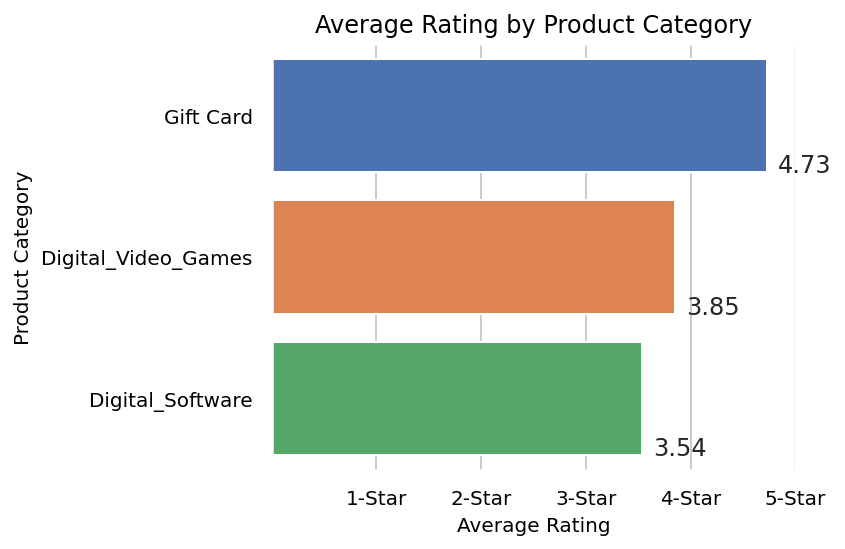

In [42]:
# Store number of categories
num_categories = df.shape[0]

# Store average star ratings
average_star_ratings = df

# Create plot
barplot = sns.barplot(y="product_category", x="avg_star_rating", data=df, saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title and x-axis ticks
plt.title("Average Rating by Product Category")
plt.xticks([1, 2, 3, 4, 5], ["1-Star", "2-Star", "3-Star", "4-Star", "5-Star"])

# Helper code to show actual values afters bars
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

#### Which Product Categories Have the Most Reviews?

In [43]:
statement = """
SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM {}.{}
GROUP BY product_category 
ORDER BY count_star_rating DESC
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,product_category,count_star_rating
0,Gift Card,149086
1,Digital_Video_Games,145431
2,Digital_Software,102084


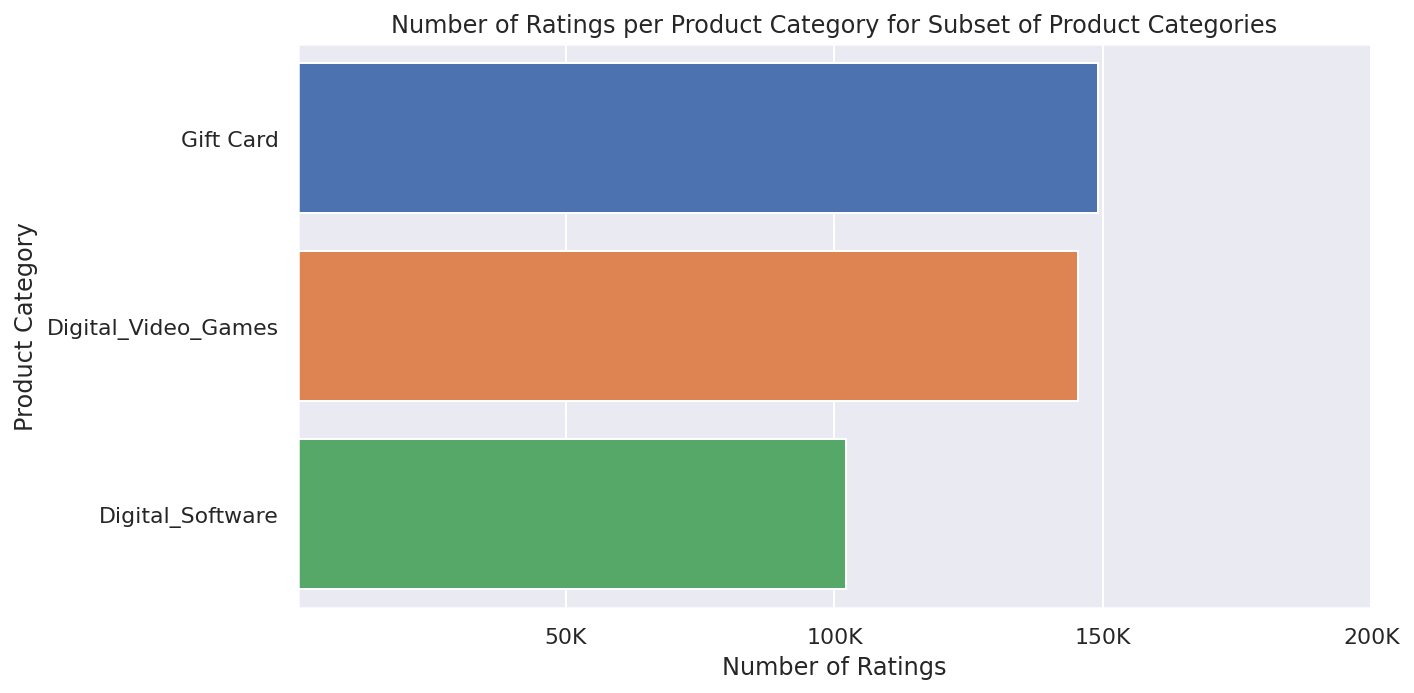

In [44]:
# Store counts
count_ratings = df["count_star_rating"]

# Store max ratings
max_ratings = df["count_star_rating"].max()

# Create Seaborn barplot
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df, saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title
plt.title("Number of Ratings per Product Category for Subset of Product Categories")

# Set x-axis ticks to match scale
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "150K", "200K"])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

#### When did each product category become available in the Amazon catalog based on the date of the first review?

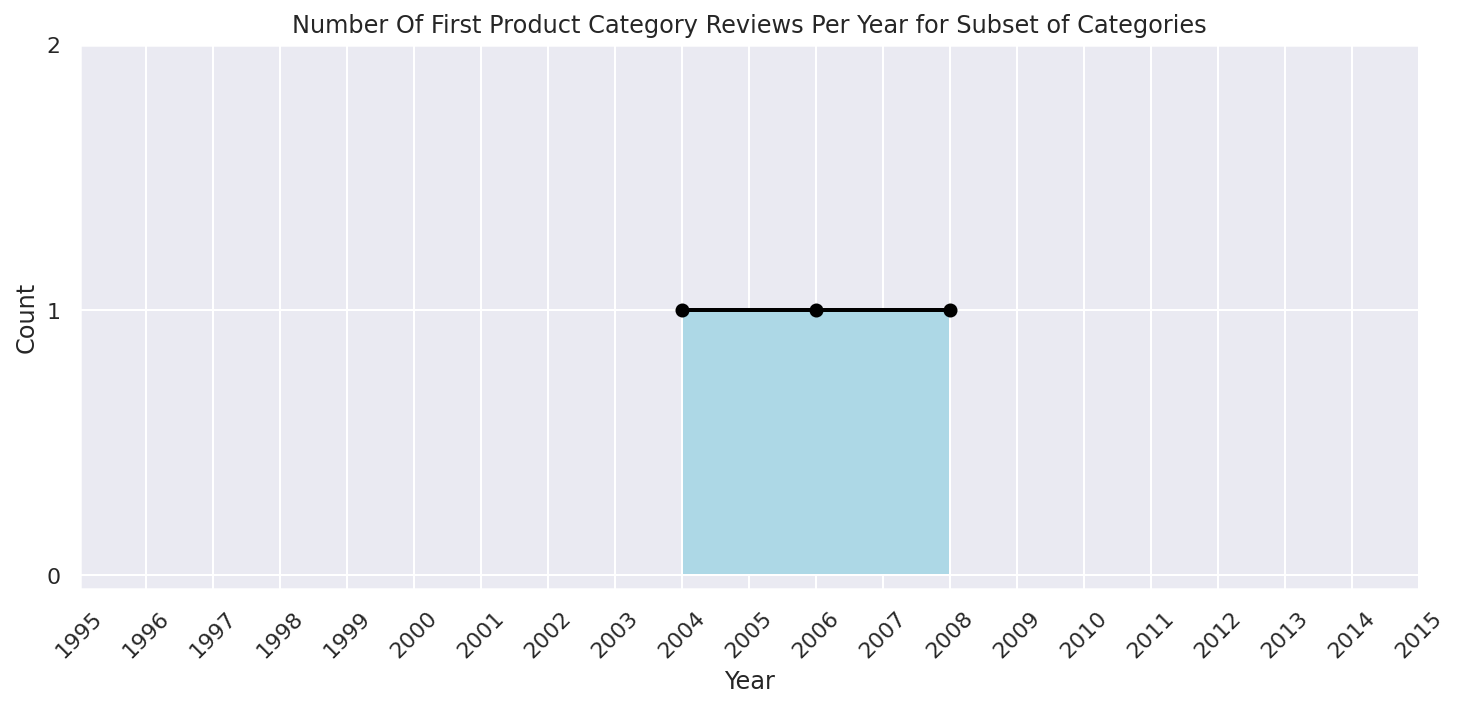

In [45]:
statement = """
SELECT product_category, MIN(review_date) AS first_review_date
FROM {}.{}
GROUP BY product_category
ORDER BY first_review_date 
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)

import datetime as datetime
dates = pd.to_datetime(df["first_review_date"])

def modify_dataframe(df):
    """ Modify dataframe to include new columns """
    df["year"] = pd.to_datetime(df["first_review_date"], format="%Y-%m-%d").dt.year
    return df

def get_x_y(df):
    """ Get X and Y coordinates; return tuple """
    series = df["year"].value_counts().sort_index()
    # new_series = series.reindex(range(1,21)).fillna(0).astype(int)
    return series.index, series.values

new_df = modify_dataframe(df)

X, Y = get_x_y(new_df)

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.set_title("Number Of First Product Category Reviews Per Year for Subset of Categories")
ax.set_xlabel("Year")
ax.set_ylabel("Count")

ax.plot(X, Y, color="black", linewidth=2, marker="o")
ax.fill_between(X, [0] * len(X), Y, facecolor="lightblue")

ax.locator_params(integer=True)

ax.set_xticks(range(1995, 2016, 1))
ax.set_yticks(range(0, max(Y) + 2, 1))

plt.xticks(rotation=45)

# fig.savefig('first_reviews_per_year.png', dpi=300)
plt.show()

#### What is the breakdown of ratings (1-5) per product category?

In [46]:
statement = """
SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM {}.{}
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,product_category,star_rating,count_reviews
0,Digital_Software,5,46410
1,Digital_Software,4,16693
2,Digital_Software,3,8308
3,Digital_Software,2,6890
4,Digital_Software,1,23783


<Figure size 720x360 with 0 Axes>

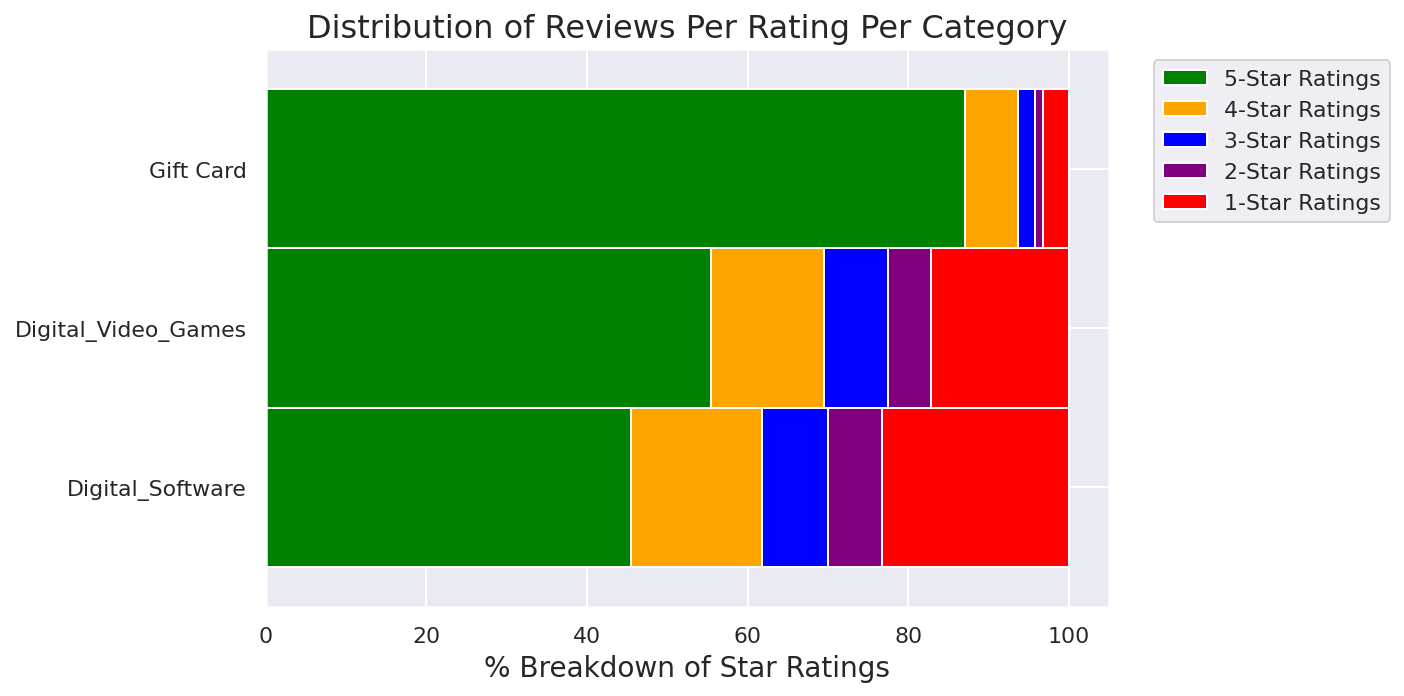

In [47]:
# Create grouped DataFrames by category and by star rating
grouped_category = df.groupby("product_category")
grouped_star = df.groupby("star_rating")

# Create sum of ratings per star rating
df_sum = df.groupby(["star_rating"]).sum()

# Calculate total number of star ratings
total = df_sum["count_reviews"].sum()

# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i = 0

for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings["star_rating"]:
        count_reviews_per_star.append(ratings.at[i, "count_reviews"])
        i = i + 1
    distribution[category] = count_reviews_per_star

# Sort distribution by average rating per category
sorted_distribution = {}

average_star_ratings.iloc[:, 0]
for index, value in average_star_ratings.iloc[:, 0].items():
    sorted_distribution[value] = distribution[value]

df_sorted_distribution_pct = pd.DataFrame(sorted_distribution).transpose().apply(
    lambda num_ratings: num_ratings/sum(num_ratings)*100, axis=1
)
df_sorted_distribution_pct.columns=['5', '4', '3', '2', '1']

categories = df_sorted_distribution_pct.index

# Plot bars
if len(categories) > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

df_sorted_distribution_pct.plot(kind="barh", 
                                stacked=True, 
                                edgecolor='white',
                                width=1.0,
                                color=['green', 
                                       'orange', 
                                       'blue', 
                                       'purple', 
                                       'red'])

plt.title("Distribution of Reviews Per Rating Per Category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['5-Star Ratings', 
                   '4-Star Ratings', 
                   '3-Star Ratings', 
                   '2-Star Ratings', 
                   '1-Star Ratings'])

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

#### How Many Reviews per Star Rating? (5, 4, 3, 2, 1)

In [48]:
statement = """
SELECT star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating DESC, count_reviews 
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,star_rating,count_reviews
0,5,256796
1,4,46958
2,3,23093
3,2,16208
4,1,53546


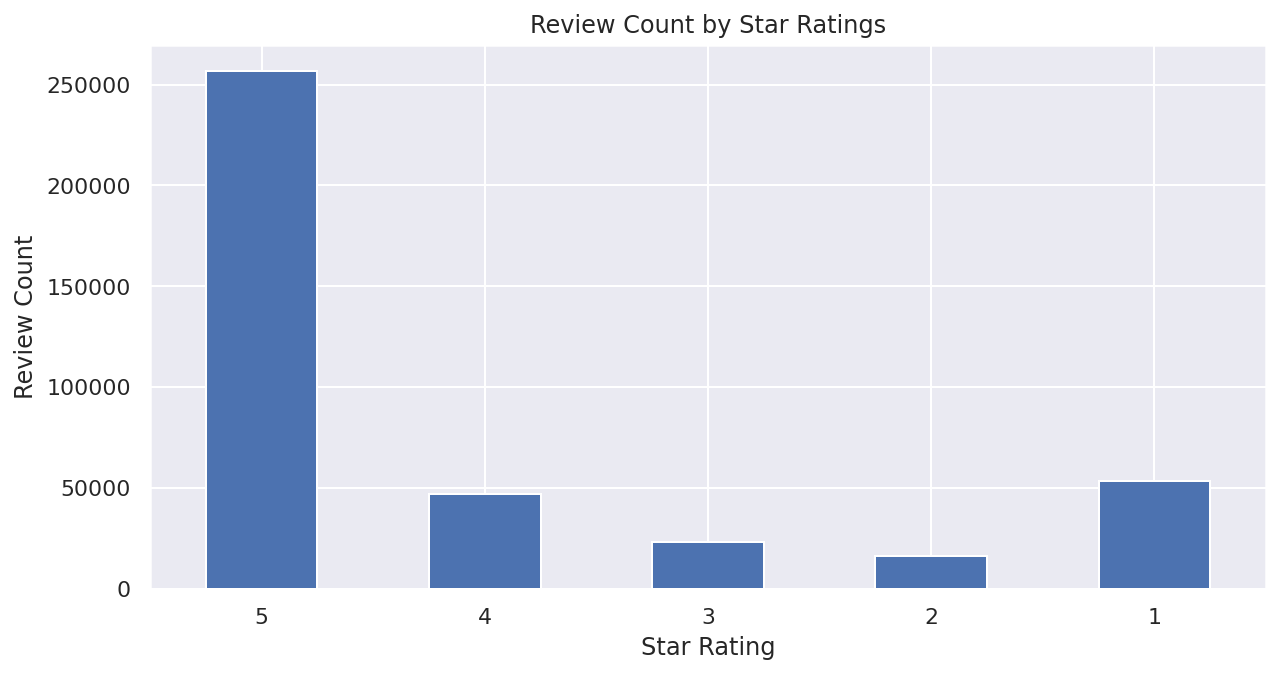

In [49]:
chart = df.plot.bar(
    x="star_rating", y="count_reviews", rot="0", figsize=(10, 5), title="Review Count by Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Review Count")

plt.show(chart)

#### How Did Star Ratings Change Over Time?

In [50]:
statement = """
SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
FROM {}.{}
GROUP BY year
ORDER BY year
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,year,avg_rating
0,2004,4.5000
1,2005,3.2759
2,2006,3.3750
3,2007,3.9500
4,2008,2.8966


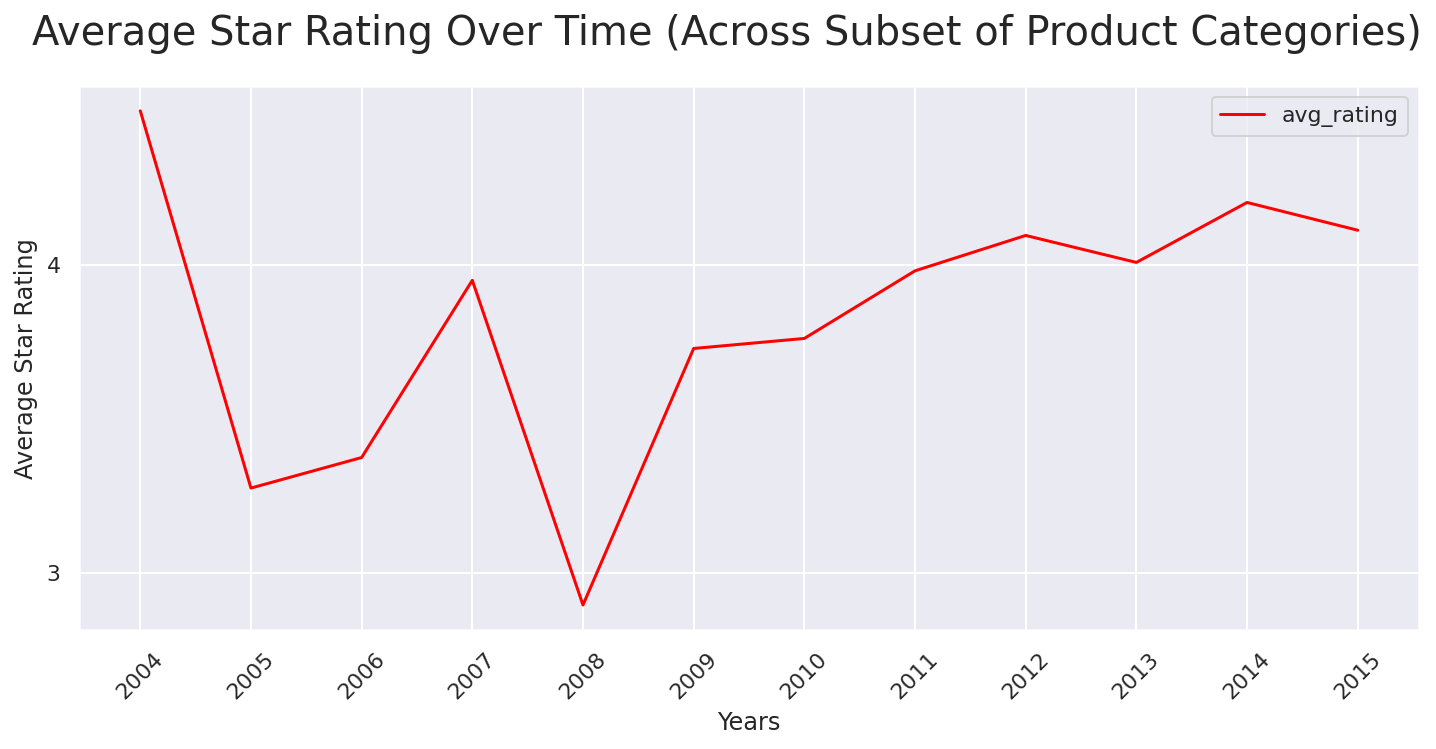

In [51]:
df["year"] = pd.to_datetime(df["year"], format="%Y").dt.year

fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time (Across Subset of Product Categories)")

ax = plt.gca()
# ax = plt.gca().set_xticks(df['year'])
ax.locator_params(integer=True)
ax.set_xticks(df["year"].unique())

df.plot(kind="line", x="year", y="avg_rating", color="red", ax=ax)

# plt.xticks(range(1995, 2016, 1))
# plt.yticks(range(0,6,1))
plt.xlabel("Years")
plt.ylabel("Average Star Rating")
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()

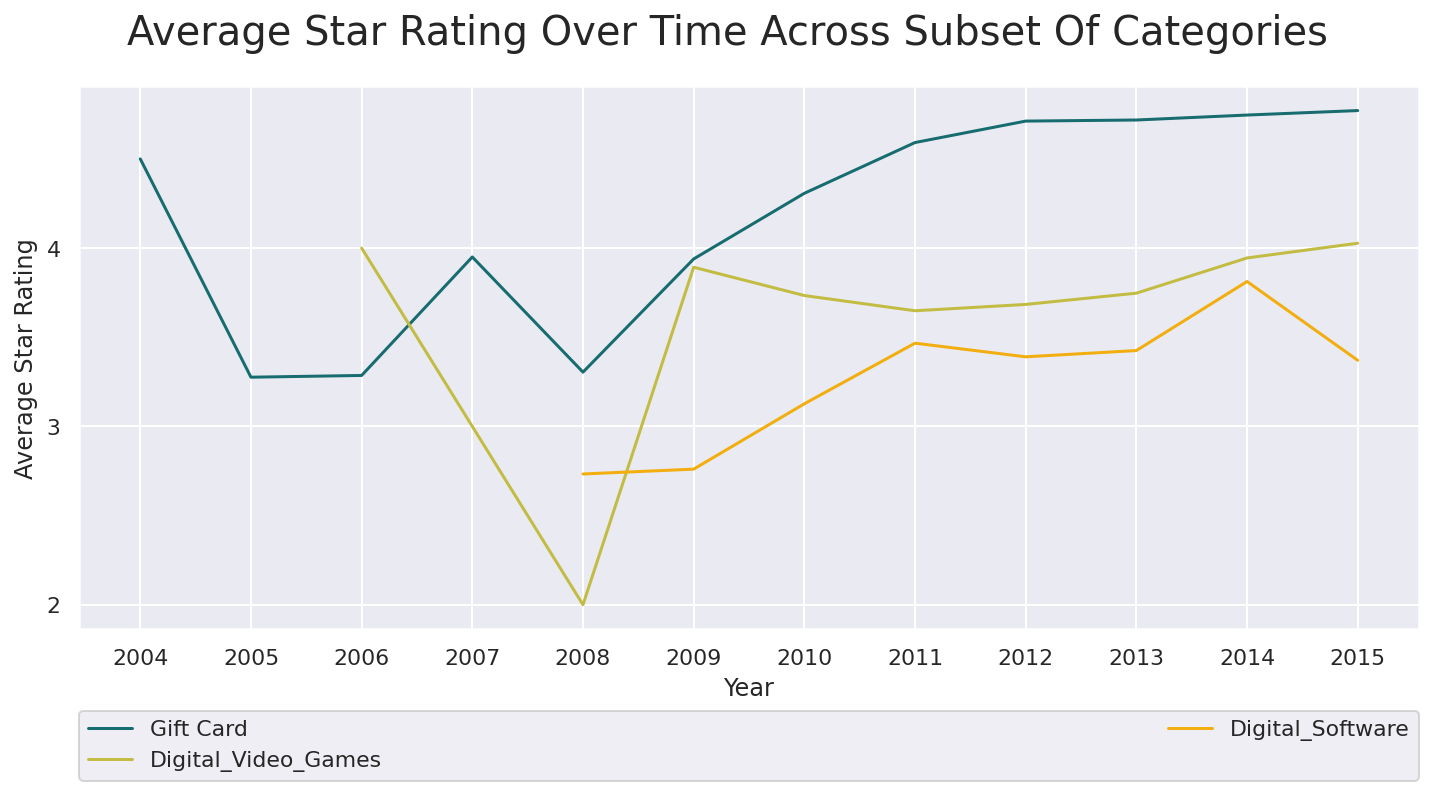

In [52]:
statement = """
SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
FROM {}.{}
GROUP BY product_category, year
ORDER BY year 
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)

def plot_categories(df):
    df_categories = df["product_category"].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df["product_category"] == category]
        df_plot.plot(
            kind="line",
            x="year",
            y="avg_rating_category",
            c=np.random.rand(
                3,
            ),
            ax=ax,
            label=category,
        )

fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time Across Subset Of Categories")

ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df["year"].unique())

plot_categories(df)

plt.xlabel("Year")
plt.ylabel("Average Star Rating")
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)

# fig.savefig('average_rating_category_all_data.png', dpi=300)
plt.show()

#### Which Star Ratings (1-5) are Most Helpful?

In [53]:
statement = """
SELECT star_rating,
         AVG(helpful_votes) AS avg_helpful_votes
FROM {}.{}
GROUP BY  star_rating
ORDER BY  star_rating ASC
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,star_rating,avg_helpful_votes
0,1,4.890729
1,2,2.493028
2,3,1.559564
3,4,1.070936
4,5,0.532497


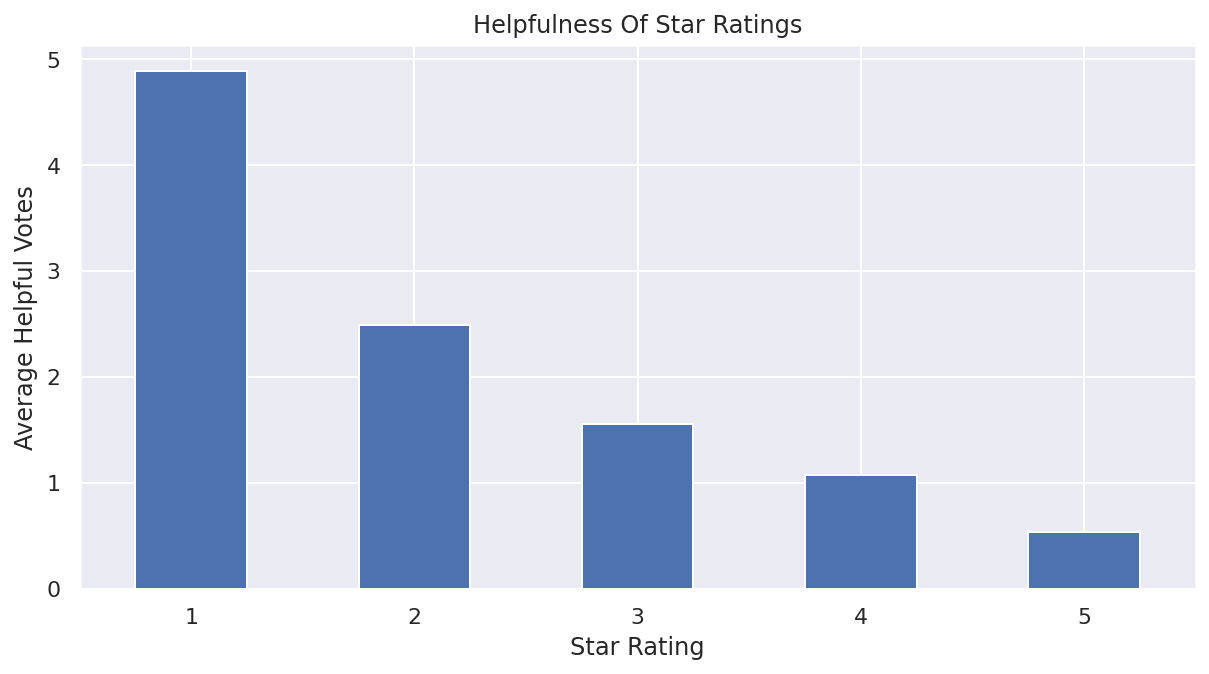

In [54]:
chart = df.plot.bar(
    x="star_rating", y="avg_helpful_votes", rot="0", figsize=(10, 5), title="Helpfulness Of Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Average Helpful Votes")

# chart.get_figure().savefig('helpful-votes.png', dpi=300)
plt.show(chart)

#### Which Products have Most Helpful Reviews? How Long are the Most Helpful Reviews?

In [55]:
statement = """
SELECT product_title,
         helpful_votes,
         star_rating,
         LENGTH(review_body) AS review_body_length,
         SUBSTR(review_body, 1, 100) AS review_body_substr
FROM {}.{}
ORDER BY helpful_votes DESC LIMIT 10 
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,product_title,helpful_votes,star_rating,review_body_length,review_body_substr
0,Amazon.com eGift Cards,5987,1,3498,"I think I am just wasting time writing this, b..."
1,TurboTax Deluxe Fed + Efile + State,5363,1,3696,I have been a loyal TurboTax customer since so...
2,SimCity - Limited Edition,5068,1,2478,Guess what? If you'd love to experience the no...
3,SimCity - Limited Edition,3789,1,1423,How would you feel if you waited for the new C...
4,Microsoft Office Home and Student 2013 (1PC/1U...,2955,1,4932,"I have never been a Microsoft hater, as many a..."


#### What is the Ratio of Positive (5, 4) to Negative (3, 2 ,1) Reviews?

In [56]:
statement = """
SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
FROM (
  SELECT count(*) AS positive_review_count
  FROM {}.{}
  WHERE star_rating >= 4
), (
  SELECT count(*) AS negative_review_count
  FROM {}.{}
  WHERE star_rating < 4
)
""".format(
    database_name, table_name, database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,positive_to_negative_sentiment_ratio
0,3.271554


#### Which Customers are Abusing the Review System by Repeatedly Reviewing the Same Product? What Was Their Average Star Rating for Each Product?

In [57]:
statement = """
SELECT customer_id, product_category, product_title, 
ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
FROM dsoaws.amazon_reviews_parquet 
GROUP BY customer_id, product_category, product_title 
HAVING COUNT(*) > 1 
ORDER BY review_count DESC
LIMIT 5
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,customer_id,product_category,product_title,avg_star_rating,review_count
0,31012456,Digital_Video_Games,Call of Duty: Black Ops II - Personalization DLC,5.0,10
1,11421705,Digital_Video_Games,BioWare Points,5.0,8
2,23587418,Digital_Video_Games,BioWare Points,5.0,6
3,30754148,Digital_Video_Games,Sims 4,4.4,5
4,14208746,Digital_Video_Games,Need For Speed World Starter Packs,1.0,4


#### What is the distribution of review lengths (number of words)?

In [58]:
statement = """
SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
FROM dsoaws.amazon_reviews_parquet
"""

df = pd.read_sql(statement, conn)
df.head()

,num_words
0,14
1,2
2,8
3,1
4,46


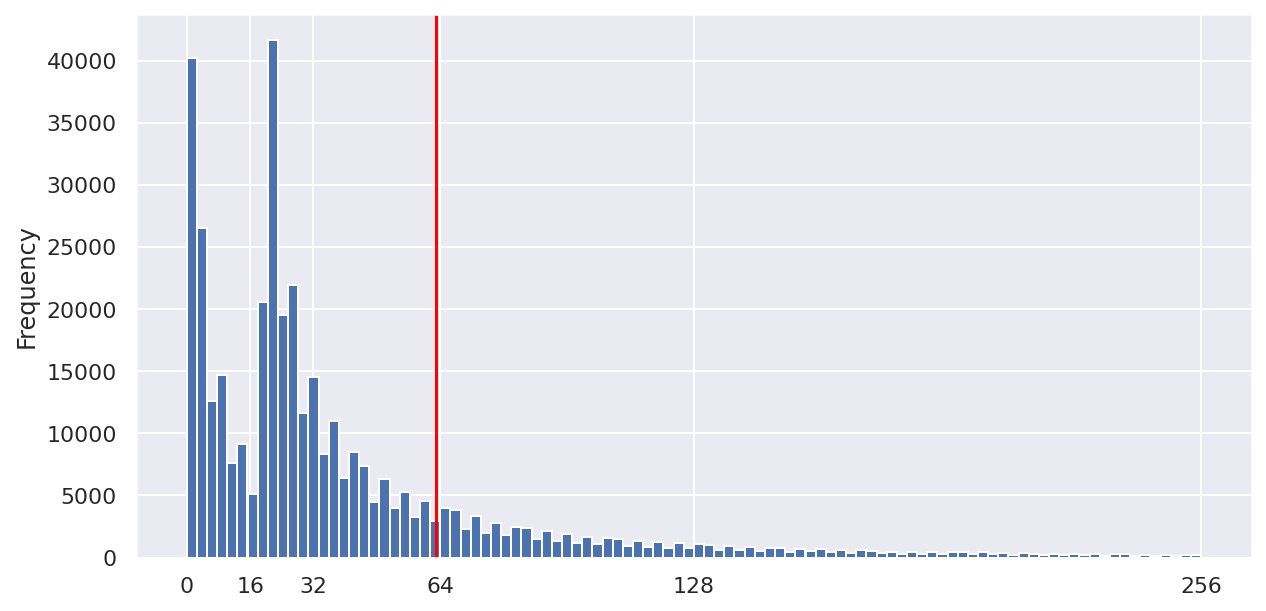

In [59]:
summary = df["num_words"].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])

df["num_words"].plot.hist(xticks=[0, 16, 32, 64, 128, 256], bins=100, range=[0, 256]).axvline(
    x=summary["80%"], c="red"
)

### Generate and Visualize Bias Reports with SageMaker Data Wrangler

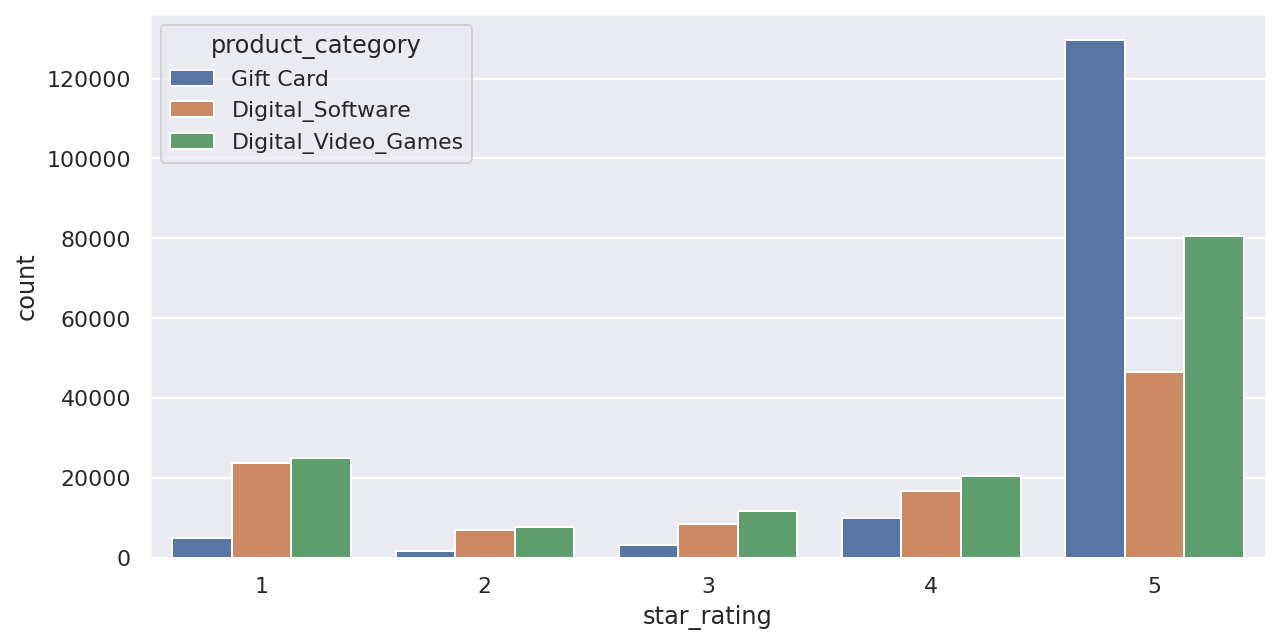

In [64]:
df_giftcard = pd.read_sql("SELECT * FROM {}.{} WHERE product_category = '{}'".format(database_name, table_name, "Gift Card"), con=conn)
df_videogames = pd.read_sql("SELECT * FROM {}.{} WHERE product_category = '{}'".format(database_name, table_name, "Digital_Video_Games"), con=conn)
df_software = pd.read_sql("SELECT * FROM {}.{} WHERE product_category = '{}'".format(database_name, table_name, "Digital_Software"), con=conn)

df = pd.concat([df_giftcard, df_software, df_videogames], ignore_index=True, sort=False)
sns.countplot(data=df, x="star_rating", hue="product_category")

In [66]:
from smclarify.bias import report
from typing import Dict
from collections import defaultdict

# Calculate Bias Metrics on Unbalanced Data
facet_column = report.FacetColumn(name="product_category")

label_column = report.LabelColumn(
    name="star_rating", 
    data=df["star_rating"], 
    positive_label_values=[5, 4]
)

# Run SageMaker Clarify Bias Report
report.bias_report(
    df=df, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

/usr/local/lib/python3.7/dist-packages/smclarify/bias/report.py:378: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(facet_column.name, 1)
/usr/local/lib/python3.7/dist-packages/smclarify/bias/report.py:384: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(label_column.name, 1)


[{'metrics': [{'description': 'Class Imbalance (CI)',
    'name': 'CI',
    'value': 0.24818142163030352},
   {'description': 'Difference in Positive Proportions in Labels (DPL)',
    'name': 'DPL',
    'value': -0.2728200784710585},
   {'description': 'Jensen-Shannon Divergence (JS)',
    'name': 'JS',
    'value': 0.06264793087463158},
   {'description': 'Kullback-Liebler Divergence (KL)',
    'name': 'KL',
    'value': 0.33123679025420116},
   {'description': 'Kolmogorov-Smirnov Distance (KS)',
    'name': 'KS',
    'value': 0.2728200784710585},
   {'description': 'L-p Norm (LP)', 'name': 'LP', 'value': 0.385825855061463},
   {'description': 'Total Variation Distance (TVD)',
    'name': 'TVD',
    'value': 0.2728200784710585}],
  'value_or_threshold': 'Gift Card'},
 {'metrics': [{'description': 'Class Imbalance (CI)',
    'name': 'CI',
    'value': 0.4852055340253807},
   {'description': 'Difference in Positive Proportions in Labels (DPL)',
    'name': 'DPL',
    'value': 0.19895613

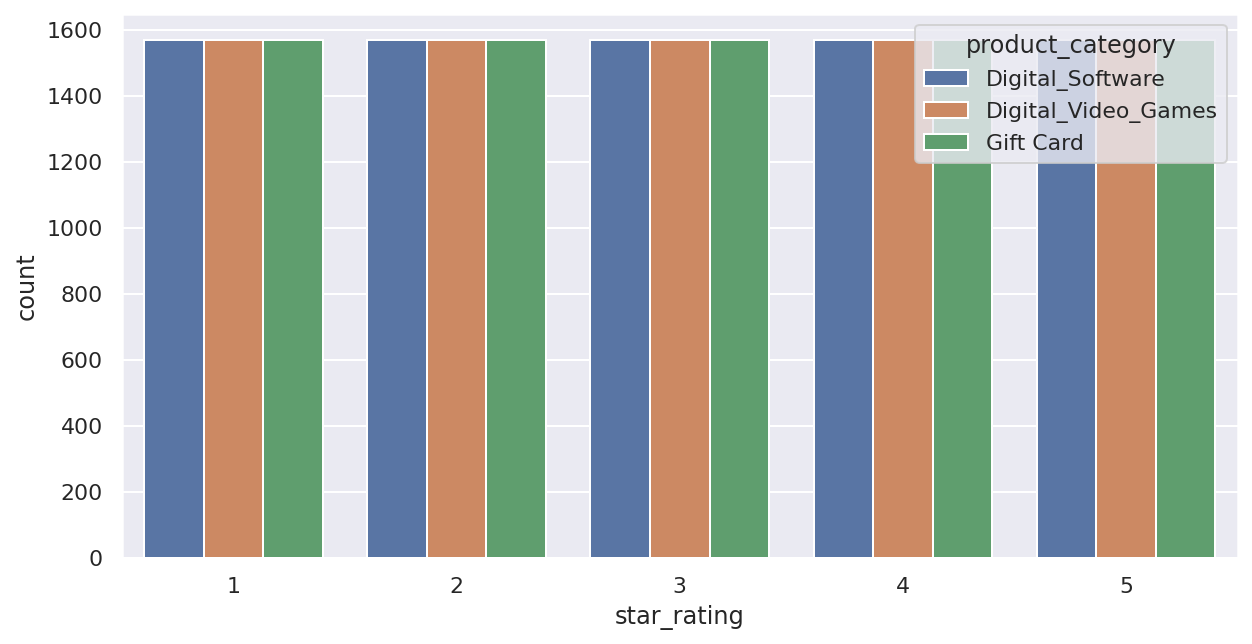

In [65]:
# Balance the Dataset by Product Category and Star Rating
df_grouped_by = df.groupby(["product_category", "star_rating"])[["product_category", "star_rating"]]
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

sns.countplot(data=df_balanced, x="star_rating", hue="product_category")

In [67]:
# Calculate Bias Metrics on Balanced Data
facet_column = report.FacetColumn(name="product_category")

label_column = report.LabelColumn(
    name="star_rating", 
    data=df_balanced["star_rating"], 
    positive_label_values=[5, 4]
)

# Run SageMaker Clarify Bias Report
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

/usr/local/lib/python3.7/dist-packages/smclarify/bias/report.py:378: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(facet_column.name, 1)
/usr/local/lib/python3.7/dist-packages/smclarify/bias/report.py:384: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(label_column.name, 1)


[{'metrics': [{'description': 'Class Imbalance (CI)',
    'name': 'CI',
    'value': 0.3333333333333333},
   {'description': 'Difference in Positive Proportions in Labels (DPL)',
    'name': 'DPL',
    'value': 0.0},
   {'description': 'Jensen-Shannon Divergence (JS)',
    'name': 'JS',
    'value': 0.0},
   {'description': 'Kullback-Liebler Divergence (KL)',
    'name': 'KL',
    'value': 0.0},
   {'description': 'Kolmogorov-Smirnov Distance (KS)',
    'name': 'KS',
    'value': 0.0},
   {'description': 'L-p Norm (LP)', 'name': 'LP', 'value': 0.0},
   {'description': 'Total Variation Distance (TVD)',
    'name': 'TVD',
    'value': 0.0}],
  'value_or_threshold': 'Digital_Software'},
 {'metrics': [{'description': 'Class Imbalance (CI)',
    'name': 'CI',
    'value': 0.3333333333333333},
   {'description': 'Difference in Positive Proportions in Labels (DPL)',
    'name': 'DPL',
    'value': 0.0},
   {'description': 'Jensen-Shannon Divergence (JS)',
    'name': 'JS',
    'value': 0.0},


We can see that all but one of the bias metrics values equal 0, which indicates an equal distribution across the three product categories. The class imbalance metric value of 0.33 is evenly balanced since we have three total product categories. The other two product categories, Digital_Software and Digital_Video_Games, also have a class imbalance metric value of 0.33.

## Data Preparation

### Convert Raw Text to BERT Features using Hugging Face and TensorFlow

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/img5.png)

We convert raw text into BERT embeddings. This will allow us to perform natural language processing tasks such as text classification. We save the features into the SageMaker Feature Store.

In [71]:
import tensorflow as tf
import collections
import json
import os
import pandas as pd
import csv
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

REVIEW_BODY_COLUMN = "review_body"
REVIEW_ID_COLUMN = "review_id"
# DATE_COLUMN = 'date'

LABEL_COLUMN = "star_rating"
LABEL_VALUES = [1, 2, 3, 4, 5]

label_map = {}
for (i, label) in enumerate(LABEL_VALUES):
    label_map[label] = i


class InputFeatures(object):
    """BERT feature vectors."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id, review_id, date, label):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        self.review_id = review_id
        self.date = date
        self.label = label
        

class Input(object):
    """A single training/test input for sequence classification."""

    def __init__(self, text, review_id, date, label=None):
        """Constructs an Input.
        Args:
          text: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
          label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.text = text
        self.review_id = review_id
        self.date = date
        self.label = label


def convert_input(the_input, max_seq_length):
    # First, we need to preprocess our data so that it matches the data BERT was trained on:
    # 1. Lowercase our text (if we're using a BERT lowercase model)
    # 2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
    # 3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
    #
    # Fortunately, the Transformers tokenizer does this for us!

    tokens = tokenizer.tokenize(the_input.text)
    tokens.insert(0, '[CLS]')
    tokens.append('[SEP]')
    print("**{} tokens**\n{}\n".format(len(tokens), tokens))

    encode_plus_tokens = tokenizer.encode_plus(
        the_input.text,
        padding='max_length',
        max_length=max_seq_length,
        truncation=True
    )

    # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
    input_ids = encode_plus_tokens["input_ids"]

    # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.
    input_mask = encode_plus_tokens["attention_mask"]

    # Segment ids are always 0 for single-sequence tasks such as text classification.  1 is used for two-sequence tasks such as question/answer and next sentence prediction.
    segment_ids = [0] * max_seq_length

    # Label for each training row (`star_rating` 1 through 5)
    label_id = label_map[the_input.label]

    features = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id,
        review_id=the_input.review_id,
        date=the_input.date,
        label=the_input.label,
    )

    print("**input_ids**\n{}\n".format(features.input_ids))
    print("**input_mask**\n{}\n".format(features.input_mask))
    print("**segment_ids**\n{}\n".format(features.segment_ids))
    print("**label_id**\n{}\n".format(features.label_id))
    print("**review_id**\n{}\n".format(features.review_id))
    print("**date**\n{}\n".format(features.date))
    print("**label**\n{}\n".format(features.label))

    return features


# We'll need to transform our data into a format that BERT understands.
# - `text` is the text we want to classify, which in this case, is the `Request` field in our Dataframe.
# - `label` is the star_rating label (1, 2, 3, 4, 5) for our training input data
def transform_inputs_to_tfrecord(inputs, output_file, max_seq_length):
    records = []
    tf_record_writer = tf.io.TFRecordWriter(output_file)

    for (input_idx, the_input) in enumerate(inputs):
        if input_idx % 10000 == 0:
            print("Writing input {} of {}\n".format(input_idx, len(inputs)))

        features = convert_input(the_input, max_seq_length)

        all_features = collections.OrderedDict()

        # Create TFRecord With input_ids, input_mask, segment_ids, and label_ids
        all_features["input_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_ids))
        all_features["input_mask"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_mask))
        all_features["segment_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.segment_ids))
        all_features["label_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[features.label_id]))

        tf_record = tf.train.Example(features=tf.train.Features(feature=all_features))
        tf_record_writer.write(tf_record.SerializeToString())

        # Create Record For Feature Store With All Features
        records.append(
            {  #'tf_record': tf_record.SerializeToString(),
                "input_ids": features.input_ids,
                "input_mask": features.input_mask,
                "segment_ids": features.segment_ids,
                "label_id": features.label_id,
                "review_id": the_input.review_id,
                "date": the_input.date,
                "label": features.label,
                #                        'review_body': features.review_body
            }
        )

    tf_record_writer.close()

    return records

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [72]:
# Feature Store requires an Event Time feature
from datetime import datetime
from time import strftime
import pandas as pd

# timestamp = datetime.now().replace(microsecond=0).isoformat()
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

data = [
    [
        5,
        "ABCD12345",
        """I needed an "antivirus" application and know the quality of Norton products.  This was a no brainer for me and I am glad it was so simple to get.""",
    ],
    [
        3,
        "EFGH12345",
        """The problem with ElephantDrive is that it requires the use of Java. Since Java is notorious for security problems I haveit removed from all of my computers. What files I do have stored are photos.""",
    ],
    [
        1,
        "IJKL2345",
        """Terrible, none of my codes worked, and I can't uninstall it.  I think this product IS malware and viruses""",
    ],
]

df = pd.DataFrame(data, columns=["star_rating", "review_id", "review_body"])

# Use the InputExample class from BERT's run_classifier code to create examples from the data
inputs = df.apply(
    lambda x: Input(label=x[LABEL_COLUMN], text=x[REVIEW_BODY_COLUMN], review_id=x[REVIEW_ID_COLUMN], date=timestamp),
    axis=1,
)
# Make sure the date is in the correct ISO-8601 format for Feature Store
print(inputs[0].date)

2022-06-09T09:43:27Z


In [74]:
inputs

0    <__main__.Input object at 0x7fc9c067cf10>
1    <__main__.Input object at 0x7fc9c067cc90>
2    <__main__.Input object at 0x7fc9c067cd90>
dtype: object

In [84]:
output_file = "./data.tfrecord"

### Add Features to SageMaker Feature Store

In [82]:
# Create FeatureGroup
'''A feature group is a logical grouping of features, defined in the Feature Store, 
to describe records. A feature group definition is composed of a list of feature 
definitions, a record identifier name, and configurations for its online and offline store.'''
'''Create feature group, describe feature group, update feature groups, delete feature 
group and list feature groups APIs can be used to manage feature groups.'''

from time import gmtime, strftime, sleep

feature_group_name = "reviews-feature-group-" + strftime("%d-%H-%M-%S", gmtime())

from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions = [
    FeatureDefinition(feature_name="input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label_id", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="review_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label", feature_type=FeatureTypeEnum.INTEGRAL),
    #    FeatureDefinition(feature_name='review_body', feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="split_type", feature_type=FeatureTypeEnum.STRING),
]

from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=sess)
print(feature_group)

# Specify record identifier and event time features
record_identifier_feature_name = "review_id"
event_time_feature_name = "date"

# Set S3 Prefix for Offline Feature Store
prefix = "reviews-feature-store-" + timestamp

# Create Feature Group
'''The last step for creating the feature group is to use the create function. 
The online store is not created by default, so we must set this as True if 
we want to enable it. The s3_uri is the location of our offline store.'''

feature_group.create(
    s3_uri=f"s3://{bucket}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role_arn,
    enable_online_store=False,
)

# Describe the Feature Group
feature_group.describe()

{'CreationTime': datetime.datetime(2022, 6, 9, 9, 56, 53, 155000, tzinfo=tzlocal()),
 'EventTimeFeatureName': 'date',
 'FeatureDefinitions': [{'FeatureName': 'input_ids', 'FeatureType': 'String'},
  {'FeatureName': 'input_mask', 'FeatureType': 'String'},
  {'FeatureName': 'segment_ids', 'FeatureType': 'String'},
  {'FeatureName': 'label_id', 'FeatureType': 'Integral'},
  {'FeatureName': 'review_id', 'FeatureType': 'String'},
  {'FeatureName': 'date', 'FeatureType': 'String'},
  {'FeatureName': 'label', 'FeatureType': 'Integral'},
  {'FeatureName': 'split_type', 'FeatureType': 'String'}],
 'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:390354360073:feature-group/reviews-feature-group-09-09-53-43',
 'FeatureGroupName': 'reviews-feature-group-09-09-53-43',
 'FeatureGroupStatus': 'Creating',
 'OfflineStoreConfig': {'DisableGlueTableCreation': False,
  'S3StorageConfig': {'ResolvedOutputS3Uri': 's3://sagemaker-us-east-1-390354360073/reviews-feature-store-2022-06-09T09:43:27Z/390354360073/s

In [87]:
# Wait For The Feature Group Creation Complete
'''Creating a feature group takes time as the data is loaded. We will need to 
wait until it is created before you can use it. You can check status using the 
following method.'''

import time

def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

wait_for_feature_group_creation_complete(feature_group=feature_group)

# Review The Records To Ingest Into Feature Store
max_seq_length = 64
records = transform_inputs_to_tfrecord(inputs, output_file, max_seq_length)

# Ingest Records into Feature Store
df_records = pd.DataFrame.from_dict(records)
df_records["split_type"] = "train"

def cast_object_to_string(data_frame):
    """Cast DataFrame Object to Supported Feature Store Data Type String"""
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")

cast_object_to_string(df_records)

# Use ingest(...) to ingest the content of a pandas DataFrame to Feature Store. 
# You can set the max_worker to the number of threads to be created to work on 
# different partitions of the data_frame in parallel.
feature_group.ingest(data_frame=df_records, max_workers=3, wait=True)

# Wait For Data In Offline Feature Store To Become Available
'''Creating a feature group takes time as the data is loaded. We will need to 
wait until it is created before we can use it.'''

offline_store_contents = None

while offline_store_contents is None:
    objects_in_bucket = s3.list_objects(Bucket=bucket, Prefix=prefix)
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
    else:
        print("Waiting for data in offline store...\n")
        sleep(60)

print("Data available.")

FeatureGroup reviews-feature-group-09-09-53-43 successfully created.
Writing input 0 of 3

**37 tokens**
['[CLS]', 'i', 'needed', 'an', '"', 'anti', '##virus', '"', 'application', 'and', 'know', 'the', 'quality', 'of', 'norton', 'products', '.', 'this', 'was', 'a', 'no', 'brain', '##er', 'for', 'me', 'and', 'i', 'am', 'glad', 'it', 'was', 'so', 'simple', 'to', 'get', '.', '[SEP]']

**input_ids**
[101, 1045, 2734, 2019, 1000, 3424, 23350, 1000, 4646, 1998, 2113, 1996, 3737, 1997, 10770, 3688, 1012, 2023, 2001, 1037, 2053, 4167, 2121, 2005, 2033, 1998, 1045, 2572, 5580, 2009, 2001, 2061, 3722, 2000, 2131, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**input_mask**
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**segment_ids**
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec5.gif)

In [ ]:
# # Get Record From Online Feature Store
# '''Use for OnlineStore serving from a FeatureStore. Only the latest records 
# stored in the OnlineStore can be retrieved. If no Record with RecordIdentifierValue 
# is found, then an empty result is returned.'''

# record_identifier_value = "IJKL2345"
# featurestore_runtime.get_record(
#     FeatureGroupName=feature_group_name, RecordIdentifierValueAsString=record_identifier_value
# )

In [89]:
# Build Training Dataset
'''SageMaker FeatureStore automatically builds the Glue Data Catalog for 
FeatureGroups (we can optionally turn it on/off while creating the FeatureGroup). 
We can create a training dataset by querying the data in the feature store. 
This is done by utilizing the auto-built Catalog and run an Athena query.'''

# Create An Athena Query
feature_store_query = feature_group.athena_query()

# Get The Feature Group Table Name
feature_store_table = feature_store_query.table_name

# Build an Athena SQL Query
'''Show Hive DDL commands to define or change structure of tables or databases 
in Hive. The schema of the table is generated based on the feature definitions. 
Columns are named after feature name and data-type are inferred based on feature type.'''

print(feature_group.as_hive_ddl())

query_string = """
SELECT input_ids, input_mask, segment_ids, label_id, split_type  FROM "{}" WHERE split_type='train' LIMIT 5
""".format(
    feature_store_table
)
print("Running " + query_string)

# Run Athena Query
'''The query results are stored in a S3 bucket.'''

feature_store_query.run(query_string=query_string, output_location="s3://" + bucket + "/" + prefix + "/query_results/")
feature_store_query.wait()

# View Query Results
dataset = pd.DataFrame()
dataset = feature_store_query.as_dataframe()
dataset

CREATE EXTERNAL TABLE IF NOT EXISTS sagemaker_featurestore.reviews-feature-group-09-09-53-43 (
  input_ids STRING
  input_mask STRING
  segment_ids STRING
  label_id INT
  review_id STRING
  date STRING
  label INT
  split_type STRING
  write_time TIMESTAMP
  event_time TIMESTAMP
  is_deleted BOOLEAN
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
  STORED AS
  INPUTFORMAT 'parquet.hive.DeprecatedParquetInputFormat'
  OUTPUTFORMAT 'parquet.hive.DeprecatedParquetOutputFormat'
LOCATION 's3://sagemaker-us-east-1-390354360073/reviews-feature-store-2022-06-09T09:43:27Z/390354360073/sagemaker/us-east-1/offline-store/reviews-feature-group-09-09-53-43-1654768613/data'
Running 
SELECT input_ids, input_mask, segment_ids, label_id, split_type  FROM "reviews-feature-group-09-09-53-43-1654768613" WHERE split_type='train' LIMIT 5



,input_ids,input_mask,segment_ids,label_id,split_type
0,"[101, 1996, 3291, 2007, 10777, 23663, 2003, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,train
1,"[101, 1045, 2734, 2019, 1000, 3424, 23350, 100...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,train
2,"[101, 6659, 1010, 3904, 1997, 2026, 9537, 2499...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,train


![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec6.gif)

In [96]:
%%writefile preprocess-scikit-text-to-bert-feature-store.py
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import functools
import multiprocessing

from datetime import datetime
from time import gmtime, strftime, sleep

import sys
import re
import collections
import argparse
import json
import os
import csv
import glob
from pathlib import Path
import time
import boto3
import subprocess

## PIP INSTALLS ##
# This is 2.3.0 (vs. 2.3.1 everywhere else) because we need to
# use anaconda and anaconda only supports 2.3.0 at this time
#subprocess.check_call([sys.executable, "-m", "conda", "install", "-c", "anaconda", "tensorflow==2.3.0", "-y"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow==2.3.1"])

import tensorflow as tf
from tensorflow import keras

subprocess.check_call([sys.executable, "-m", "conda", "install", "-c", "conda-forge", "transformers==3.5.1", "-y"])
from transformers import DistilBertTokenizer
from transformers import DistilBertConfig

subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib==3.2.1"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "sagemaker==2.24.1"])
import pandas as pd
import re
import sagemaker
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

region = os.environ["AWS_DEFAULT_REGION"]
print("Region: {}".format(region))

#############################
## We may need to get the Role and Bucket before setting sm, featurestore_runtime, etc.
## Role and Bucket are malformed if we do this later.
sts = boto3.Session(region_name=region).client(service_name="sts", region_name=region)

caller_identity = sts.get_caller_identity()
print("caller_identity: {}".format(caller_identity))

assumed_role_arn = caller_identity["Arn"]
print("(assumed_role) caller_identity_arn: {}".format(assumed_role_arn))

assumed_role_name = assumed_role_arn.split("/")[-2]

iam = boto3.Session(region_name=region).client(service_name="iam", region_name=region)
get_role_response = iam.get_role(RoleName=assumed_role_name)
print("get_role_response {}".format(get_role_response))
role = get_role_response["Role"]["Arn"]
print("role {}".format(role))

bucket = sagemaker.Session().default_bucket()
print("The DEFAULT BUCKET is {}".format(bucket))
#############################

sm = boto3.Session(region_name=region).client(service_name="sagemaker", region_name=region)

featurestore_runtime = boto3.Session(region_name=region).client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

s3 = boto3.Session(region_name=region).client(service_name="s3", region_name=region)

sagemaker_session = sagemaker.Session(
    boto_session=boto3.Session(region_name=region),
    sagemaker_client=sm,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

REVIEW_BODY_COLUMN = "review_body"
REVIEW_ID_COLUMN = "review_id"
# DATE_COLUMN = 'date'

LABEL_COLUMN = "star_rating"
LABEL_VALUES = [1, 2, 3, 4, 5]

label_map = {}
for (i, label) in enumerate(LABEL_VALUES):
    label_map[label] = i


def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")
    return data_frame


def wait_for_feature_group_creation_complete(feature_group):
    try:
        status = feature_group.describe().get("FeatureGroupStatus")
        print("Feature Group status: {}".format(status))
        while status == "Creating":
            print("Waiting for Feature Group Creation")
            time.sleep(5)
            status = feature_group.describe().get("FeatureGroupStatus")
            print("Feature Group status: {}".format(status))
        if status != "Created":
            print("Feature Group status: {}".format(status))
            raise RuntimeError(f"Failed to create feature group {feature_group.name}")
        print(f"FeatureGroup {feature_group.name} successfully created.")
    except:
        print("No feature group created yet.")


def create_or_load_feature_group(prefix, feature_group_name):

    # Feature Definitions for our records
    feature_definitions = [
        FeatureDefinition(feature_name="input_ids", feature_type=FeatureTypeEnum.STRING),
        FeatureDefinition(feature_name="input_mask", feature_type=FeatureTypeEnum.STRING),
        FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
        FeatureDefinition(feature_name="label_id", feature_type=FeatureTypeEnum.INTEGRAL),
        FeatureDefinition(feature_name="review_id", feature_type=FeatureTypeEnum.STRING),
        FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
        FeatureDefinition(feature_name="label", feature_type=FeatureTypeEnum.INTEGRAL),
        #        FeatureDefinition(feature_name='review_body', feature_type=FeatureTypeEnum.STRING),
        FeatureDefinition(feature_name="split_type", feature_type=FeatureTypeEnum.STRING),
    ]

    feature_group = FeatureGroup(
        name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=sagemaker_session
    )

    print("Feature Group: {}".format(feature_group))

    try:
        print(
            "Waiting for existing Feature Group to become available if it is being created by another instance in our cluster..."
        )
        wait_for_feature_group_creation_complete(feature_group)
    except Exception as e:
        print("Before CREATE FG wait exeption: {}".format(e))
    #        pass

    try:
        record_identifier_feature_name = "review_id"
        event_time_feature_name = "date"

        print("Creating Feature Group with role {}...".format(role))
        feature_group.create(
            s3_uri=f"s3://{bucket}/{prefix}",
            record_identifier_name=record_identifier_feature_name,
            event_time_feature_name=event_time_feature_name,
            role_arn=role,
            enable_online_store=False,
        )
        print("Creating Feature Group. Completed.")

        print("Waiting for new Feature Group to become available...")
        wait_for_feature_group_creation_complete(feature_group)
        print("Feature Group available.")
        feature_group.describe()

    except Exception as e:
        print("Exception: {}".format(e))

    return feature_group


class InputFeatures(object):
    """BERT feature vectors."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id, review_id, date, label):
        #               review_body):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        self.review_id = review_id
        self.date = date
        self.label = label


#        self.review_body = review_body


class Input(object):
    """A single training/test input for sequence classification."""

    def __init__(self, text, review_id, date, label=None):
        """Constructs an Input.
        Args:
          text: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
          label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.text = text
        self.review_id = review_id
        self.date = date
        self.label = label


def convert_input(the_input, max_seq_length):
    # First, we need to preprocess our data so that it matches the data BERT was trained on:
    #
    # 1. Lowercase our text (if we're using a BERT lowercase model)
    # 2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
    # 3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
    #
    # Fortunately, the Transformers tokenizer does this for us!
    #
    tokens = tokenizer.tokenize(the_input.text)

    # Next, we need to do the following:
    #
    # 4. Map our words to indexes using a vocab file that BERT provides
    # 5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
    # 6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))
    #
    # Again, the Transformers tokenizer does this for us!
    #
    encode_plus_tokens = tokenizer.encode_plus(
        the_input.text,
        padding='max_length',
        max_length=max_seq_length,
        truncation=True
    )

    # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
    input_ids = encode_plus_tokens["input_ids"]

    # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.
    input_mask = encode_plus_tokens["attention_mask"]

    # Segment ids are always 0 for single-sequence tasks such as text classification.  1 is used for two-sequence tasks such as question/answer and next sentence prediction.
    segment_ids = [0] * max_seq_length

    # Label for each training row (`star_rating` 1 through 5)
    label_id = label_map[the_input.label]

    features = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id,
        review_id=the_input.review_id,
        date=the_input.date,
        label=the_input.label,
    )
    #        review_body=the_input.text)

    #     print('**input_ids**\n{}\n'.format(features.input_ids))
    #     print('**input_mask**\n{}\n'.format(features.input_mask))
    #     print('**segment_ids**\n{}\n'.format(features.segment_ids))
    #     print('**label_id**\n{}\n'.format(features.label_id))
    #     print('**review_id**\n{}\n'.format(features.review_id))
    #     print('**date**\n{}\n'.format(features.date))
    #     print('**label**\n{}\n'.format(features.label))
    #    print('**review_body**\n{}\n'.format(features.review_body))

    return features


def transform_inputs_to_tfrecord(inputs, output_file, max_seq_length):
    """Convert a set of `Input`s to a TFRecord file."""

    records = []

    tf_record_writer = tf.io.TFRecordWriter(output_file)

    for (input_idx, the_input) in enumerate(inputs):
        if input_idx % 10000 == 0:
            print("Writing input {} of {}\n".format(input_idx, len(inputs)))

        features = convert_input(the_input, max_seq_length)

        all_features = collections.OrderedDict()
        all_features["input_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_ids))
        all_features["input_mask"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_mask))
        all_features["segment_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.segment_ids))
        all_features["label_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[features.label_id]))

        tf_record = tf.train.Example(features=tf.train.Features(feature=all_features))
        tf_record_writer.write(tf_record.SerializeToString())

        records.append(
            {  #'tf_record': tf_record.SerializeToString(),
                "input_ids": features.input_ids,
                "input_mask": features.input_mask,
                "segment_ids": features.segment_ids,
                "label_id": features.label_id,
                "review_id": the_input.review_id,
                "date": the_input.date,
                "label": features.label,
                #                        'review_body': features.review_body
            }
        )

        #####################################
        ####### TODO:  REMOVE THIS BREAK #######
        #####################################
        # break

    tf_record_writer.close()

    return records


def list_arg(raw_value):
    """argparse type for a list of strings"""
    return str(raw_value).split(",")


def parse_args():
    # Unlike SageMaker training jobs (which have `SM_HOSTS` and `SM_CURRENT_HOST` env vars), processing jobs to need to parse the resource config file directly
    resconfig = {}
    try:
        with open("/opt/ml/config/resourceconfig.json", "r") as cfgfile:
            resconfig = json.load(cfgfile)
    except FileNotFoundError:
        print("/opt/ml/config/resourceconfig.json not found.  current_host is unknown.")
        pass  # Ignore

    # Local testing with CLI args
    parser = argparse.ArgumentParser(description="Process")

    parser.add_argument(
        "--hosts",
        type=list_arg,
        default=resconfig.get("hosts", ["unknown"]),
        help="Comma-separated list of host names running the job",
    )
    parser.add_argument(
        "--current-host",
        type=str,
        default=resconfig.get("current_host", "unknown"),
        help="Name of this host running the job",
    )
    parser.add_argument(
        "--input-data",
        type=str,
        default="/opt/ml/processing/input/data",
    )
    parser.add_argument(
        "--output-data",
        type=str,
        default="/opt/ml/processing/output",
    )
    parser.add_argument(
        "--train-split-percentage",
        type=float,
        default=0.90,
    )
    parser.add_argument(
        "--validation-split-percentage",
        type=float,
        default=0.05,
    )
    parser.add_argument(
        "--test-split-percentage",
        type=float,
        default=0.05,
    )
    parser.add_argument("--balance-dataset", type=eval, default=True)
    parser.add_argument(
        "--max-seq-length",
        type=int,
        default=64,
    )
    parser.add_argument(
        "--feature-store-offline-prefix",
        type=str,
        default=None,
    )
    parser.add_argument(
        "--feature-group-name",
        type=str,
        default=None,
    )

    return parser.parse_args()


def _transform_tsv_to_tfrecord(file, max_seq_length, balance_dataset, prefix, feature_group_name):
    print("file {}".format(file))
    print("max_seq_length {}".format(max_seq_length))
    print("balance_dataset {}".format(balance_dataset))
    print("prefix {}".format(prefix))
    print("feature_group_name {}".format(feature_group_name))

    # need to re-load since we can't pass feature_group object in _partial functions for some reason
    feature_group = create_or_load_feature_group(prefix, feature_group_name)

    filename_without_extension = Path(Path(file).stem).stem

    df = pd.read_csv(file, delimiter="\t", quoting=csv.QUOTE_NONE, compression="gzip")

    df.isna().values.any()
    df = df.dropna()
    df = df.reset_index(drop=True)

    print("Shape of dataframe {}".format(df.shape))

    if balance_dataset:
        # Balance the dataset down to the minority class
        df_grouped_by = df.groupby(["star_rating"]) 
        df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

        df_balanced = df_balanced.reset_index(drop=True)
        print("Shape of balanced dataframe {}".format(df_balanced.shape))
        
        print(df_balanced["star_rating"].head(100))

        df = df_balanced

    print("Shape of dataframe before splitting {}".format(df.shape))

    print("train split percentage {}".format(args.train_split_percentage))
    print("validation split percentage {}".format(args.validation_split_percentage))
    print("test split percentage {}".format(args.test_split_percentage))

    holdout_percentage = 1.00 - args.train_split_percentage
    print("holdout percentage {}".format(holdout_percentage))
    
    df_train, df_holdout = train_test_split(df, test_size=holdout_percentage, stratify=df["star_rating"])

    test_holdout_percentage = args.test_split_percentage / holdout_percentage
    
    print("test holdout percentage {}".format(test_holdout_percentage))
    
    df_validation, df_test = train_test_split(
        df_holdout, test_size=test_holdout_percentage, stratify=df_holdout["star_rating"])

    df_train = df_train.reset_index(drop=True)
    df_validation = df_validation.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    print("Shape of train dataframe {}".format(df_train.shape))
    print("Shape of validation dataframe {}".format(df_validation.shape))
    print("Shape of test dataframe {}".format(df_test.shape))

    timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
    print(timestamp)

    train_inputs = df_train.apply(
        lambda x: Input(
            label=x[LABEL_COLUMN], text=x[REVIEW_BODY_COLUMN], review_id=x[REVIEW_ID_COLUMN], date=timestamp
        ),
        axis=1,
    )

    validation_inputs = df_validation.apply(
        lambda x: Input(
            label=x[LABEL_COLUMN], text=x[REVIEW_BODY_COLUMN], review_id=x[REVIEW_ID_COLUMN], date=timestamp
        ),
        axis=1,
    )

    test_inputs = df_test.apply(
        lambda x: Input(
            label=x[LABEL_COLUMN], text=x[REVIEW_BODY_COLUMN], review_id=x[REVIEW_ID_COLUMN], date=timestamp
        ),
        axis=1,
    )

    # Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):
    #
    #
    # 1. Lowercase our text (if we're using a BERT lowercase model)
    # 2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
    # 3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
    # 4. Map our words to indexes using a vocab file that BERT provides
    # 5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
    # 6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))
    #
    # We don't have to worry about these details.  The Transformers tokenizer does this for us.
    #
    train_data = "{}/bert/train".format(args.output_data)
    validation_data = "{}/bert/validation".format(args.output_data)
    test_data = "{}/bert/test".format(args.output_data)

    # Convert our train and validation features to InputFeatures (.tfrecord protobuf) that works with BERT and TensorFlow.
    train_records = transform_inputs_to_tfrecord(
        train_inputs,
        "{}/part-{}-{}.tfrecord".format(train_data, args.current_host, filename_without_extension),
        max_seq_length,
    )

    validation_records = transform_inputs_to_tfrecord(
        validation_inputs,
        "{}/part-{}-{}.tfrecord".format(validation_data, args.current_host, filename_without_extension),
        max_seq_length,
    )

    test_records = transform_inputs_to_tfrecord(
        test_inputs,
        "{}/part-{}-{}.tfrecord".format(test_data, args.current_host, filename_without_extension),
        max_seq_length,
    )

    df_train_records = pd.DataFrame.from_dict(train_records)
    df_train_records["split_type"] = "train"
    df_train_records.head()

    df_validation_records = pd.DataFrame.from_dict(validation_records)
    df_validation_records["split_type"] = "validation"
    df_validation_records.head()

    df_test_records = pd.DataFrame.from_dict(test_records)
    df_test_records["split_type"] = "test"
    df_test_records.head()

    # Add record to feature store
    df_fs_train_records = cast_object_to_string(df_train_records)
    df_fs_validation_records = cast_object_to_string(df_validation_records)
    df_fs_test_records = cast_object_to_string(df_test_records)

    print("Ingesting Features...")
    feature_group.ingest(data_frame=df_fs_train_records, max_workers=3, wait=True)
    feature_group.ingest(data_frame=df_fs_validation_records, max_workers=3, wait=True)
    feature_group.ingest(data_frame=df_fs_test_records, max_workers=3, wait=True)
    
    offline_store_status = None
    while offline_store_status != 'Active':
        try:
            offline_store_status = feature_group.describe()['OfflineStoreStatus']['Status']
        except:
            pass
        print('Offline store status: {}'.format(offline_store_status))    
    print('...features ingested!')


def process(args):
    print("Current host: {}".format(args.current_host))

    feature_group = create_or_load_feature_group(
        prefix=args.feature_store_offline_prefix, feature_group_name=args.feature_group_name
    )

    feature_group.describe()

    print(feature_group.as_hive_ddl())

    train_data = "{}/bert/train".format(args.output_data)
    validation_data = "{}/bert/validation".format(args.output_data)
    test_data = "{}/bert/test".format(args.output_data)

    transform_tsv_to_tfrecord = functools.partial(
        _transform_tsv_to_tfrecord,
        max_seq_length=args.max_seq_length,
        balance_dataset=args.balance_dataset,
        prefix=args.feature_store_offline_prefix,
        feature_group_name=args.feature_group_name,
    )

    input_files = glob.glob("{}/*.tsv.gz".format(args.input_data))

    num_cpus = multiprocessing.cpu_count()
    print("num_cpus {}".format(num_cpus))

    p = multiprocessing.Pool(num_cpus)
    p.map(transform_tsv_to_tfrecord, input_files)

    print("Listing contents of {}".format(args.output_data))
    dirs_output = os.listdir(args.output_data)
    for file in dirs_output:
        print(file)

    print("Listing contents of {}".format(train_data))
    dirs_output = os.listdir(train_data)
    for file in dirs_output:
        print(file)

    print("Listing contents of {}".format(validation_data))
    dirs_output = os.listdir(validation_data)
    for file in dirs_output:
        print(file)

    print("Listing contents of {}".format(test_data))
    dirs_output = os.listdir(test_data)
    for file in dirs_output:
        print(file)

    offline_store_contents = None
    while offline_store_contents is None:
        objects_in_bucket = s3.list_objects(Bucket=bucket, Prefix=args.feature_store_offline_prefix)
        if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
            offline_store_contents = objects_in_bucket["Contents"]
        else:
            print("Waiting for data in offline store...\n")
            sleep(60)

    print("Data available.")

    print("Complete")


if __name__ == "__main__":
    args = parse_args()
    print("Loaded arguments:")
    print(args)

    print("Environment variables:")
    print(os.environ)

    process(args)

Writing preprocess-scikit-text-to-bert-feature-store.py


Run this script as a processing job. You also need to specify one ProcessingInput with the source argument of the Amazon S3 bucket and destination is where the script reads this data from /opt/ml/processing/input (inside the Docker container.) All local paths inside the processing container must begin with /opt/ml/processing/.

Also give the run() method a ProcessingOutput, where the source is the path the script writes output data to. For outputs, the destination defaults to an S3 bucket that the Amazon SageMaker Python SDK creates for you, following the format s3://sagemaker-<region>-<account_id>/<processing_job_name>/output/<output_name>/. You also give the ProcessingOutput value for output_name, to make it easier to retrieve these output artifacts after the job is run.

The arguments parameter in the run() method are command-line arguments in our preprocess-scikit-text-to-bert-feature-store.py script.

Note that we sharding the data using ShardedByS3Key to spread the transformations across all worker nodes in the cluster.

### Create Experiment and Process Data

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/img6.png)

- Experiment: A collection of related Trials. Add Trials to an Experiment that you wish to compare together.
- Trial: A description of a multi-step machine learning workflow. Each step in the workflow is described by a Trial Component. There is no relationship between Trial Components such as ordering.
- Trial Component: A description of a single step in a machine learning workflow. For example data cleaning, feature extraction, model training, model evaluation, etc.
- Tracker: A logger of information about a single TrialComponent.

In [5]:
# Create the Experiment
import time
from smexperiments.experiment import Experiment

timestamp = int(time.time())

experiment = Experiment.create(
    experiment_name="Amazon-Customer-Reviews-BERT-Experiment-{}".format(timestamp),
    description="Amazon Customer Reviews BERT Experiment",
    sagemaker_boto_client=sm,
)

experiment_name = experiment.experiment_name
print("Experiment name: {}".format(experiment_name))

Experiment name: Amazon-Customer-Reviews-BERT-Experiment-1654775428


In [6]:
# Create the Trial
import time
from smexperiments.trial import Trial

timestamp = int(time.time())

trial = Trial.create(
    trial_name="trial-{}".format(timestamp), experiment_name=experiment_name, sagemaker_boto_client=sm
)

trial_name = trial.trial_name
print("Trial name: {}".format(trial_name))

Trial name: trial-1654775455


In [7]:
# Create the Experiment Config
experiment_config = {
    "ExperimentName": experiment_name,
    "TrialName": trial_name,
    "TrialComponentDisplayName": "prepare",
}

In [8]:
# Create Feature Store and Feature Group
timestamp = int(time.time())
feature_store_offline_prefix = "reviews-feature-store-" + str(timestamp)
feature_group_name = "reviews-feature-group-" + str(timestamp)

from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions = [
    FeatureDefinition(feature_name="input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label_id", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="review_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label", feature_type=FeatureTypeEnum.INTEGRAL),
    #    FeatureDefinition(feature_name='review_body', feature_type=FeatureTypeEnum.STRING)
]

from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=sess)

In [24]:
# Set the Processing Job Hyper-Parameters
processing_instance_type = "ml.c5.2xlarge"
processing_instance_count = 2
train_split_percentage = 0.90
validation_split_percentage = 0.05
test_split_percentage = 0.05
balance_dataset = True
max_seq_length = 64

In [12]:
# Choosing a max_seq_length for BERT
'''Review length 63 represents the 80th percentile for this dataset. 
However, it's best to stick with powers-of-2 when using BERT. So let's 
choose 64 as this is the smallest power-of-2 greater than 63. Reviews with 
length > 64 will be truncated to 64.'''

from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={"AWS_DEFAULT_REGION": region},
    max_runtime_in_seconds=7200,
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [13]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

processor.run(
    code="preprocess-scikit-text-to-bert-feature-store.py",
    inputs=[
        ProcessingInput(
            input_name="raw-input-data",
            source="s3://{}/amazon-reviews-pds/tsv/".format(bucket),
            destination="/opt/ml/processing/input/data/",
            s3_data_distribution_type="ShardedByS3Key",
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="bert-train", s3_upload_mode="EndOfJob", source="/opt/ml/processing/output/bert/train"
        ),
        ProcessingOutput(
            output_name="bert-validation",
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/validation",
        ),
        ProcessingOutput(
            output_name="bert-test", s3_upload_mode="EndOfJob", source="/opt/ml/processing/output/bert/test"
        ),
    ],
    arguments=[
        "--train-split-percentage",
        str(train_split_percentage),
        "--validation-split-percentage",
        str(validation_split_percentage),
        "--test-split-percentage",
        str(test_split_percentage),
        "--max-seq-length",
        str(max_seq_length),
        "--balance-dataset",
        str(balance_dataset),
        "--feature-store-offline-prefix",
        str(feature_store_offline_prefix),
        "--feature-group-name",
        str(feature_group_name),
    ],
    experiment_config=experiment_config,
    logs=True,
    wait=False,
)

scikit_processing_job_name = processor.jobs[-1].describe()["ProcessingJobName"]
print(scikit_processing_job_name)

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2022-06-09-11-58-05-034



Job Name:  sagemaker-scikit-learn-2022-06-09-11-58-05-034
Inputs:  [{'InputName': 'raw-input-data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv/', 'LocalPath': '/opt/ml/processing/input/data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/input/code/preprocess-scikit-text-to-bert-feature-store.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'bert-train', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-train', 'LocalPath': '/opt/ml/processing/output/bert/train

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, scikit_processing_job_name
        )
    )
)
display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, scikit_processing_job_name
        )
    )
)
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, scikit_processing_job_name, region
        )
    )
)

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec9.gif)

In [15]:
# Monitor the Processing Job
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()
running_processor.wait(logs=False)

...................................................................................................................!

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec7.gif)

In [16]:
# Inspect the Processed Output Data
processing_job_description = running_processor.describe()

output_config = processing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "bert-train":
        processed_train_data_s3_uri = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "bert-validation":
        processed_validation_data_s3_uri = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "bert-test":
        processed_test_data_s3_uri = output["S3Output"]["S3Uri"]

print(processed_train_data_s3_uri)
print(processed_validation_data_s3_uri)
print(processed_test_data_s3_uri)

s3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-train
s3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-validation
s3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-test


In [17]:
!aws s3 ls $processed_train_data_s3_uri/

2022-06-09 12:10:13   10472196 part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord
2022-06-09 12:10:13    2315618 part-algo-1-amazon_reviews_us_Gift_Card_v1_00.tfrecord
2022-06-09 12:10:18   11712540 part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord


In [18]:
!aws s3 ls $processed_validation_data_s3_uri/

2022-06-09 12:10:13     581560 part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord
2022-06-09 12:10:13     128421 part-algo-1-amazon_reviews_us_Gift_Card_v1_00.tfrecord
2022-06-09 12:10:18     649786 part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord


In [19]:
!aws s3 ls $processed_test_data_s3_uri/

2022-06-09 12:10:14     581912 part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord
2022-06-09 12:10:14     129020 part-algo-1-amazon_reviews_us_Gift_Card_v1_00.tfrecord
2022-06-09 12:10:19     650765 part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord


### Query The Feature Store

In [20]:
feature_store_query = feature_group.athena_query()
feature_store_table = feature_store_query.table_name

query_string = """
SELECT input_ids, input_mask, segment_ids, label_id, split_type  FROM "{}" WHERE split_type='train' LIMIT 5
""".format(
    feature_store_table
)

print("Running " + query_string)

feature_store_query.run(
    query_string=query_string,
    output_location="s3://" + bucket + "/" + feature_store_offline_prefix + "/query_results/",
)

feature_store_query.wait()

feature_store_query.as_dataframe()

Running 
SELECT input_ids, input_mask, segment_ids, label_id, split_type  FROM "reviews-feature-group-1654775576-1654776243" WHERE split_type='train' LIMIT 5



INFO:sagemaker:Query 42af9db1-3987-4821-a264-2abe94d59d5a is being executed.
INFO:sagemaker:Query 42af9db1-3987-4821-a264-2abe94d59d5a successfully executed.


,input_ids,input_mask,segment_ids,label_id,split_type
0,"[101, 1045, 2001, 2667, 2000, 4604, 2009, 2004...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,train
1,"[101, 1045, 2066, 1996, 7496, 1997, 6016, 5592...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,train
2,"[101, 1045, 2052, 2022, 2488, 2583, 2000, 3446...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,train
3,"[101, 3835, 4003, 1012, 102, 0, 0, 0, 0, 0, 0,...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,train
4,"[101, 2004, 2071, 2022, 3517, 1997, 1037, 5592...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,train


### Show the Experiment Tracking Lineage

In [6]:
from sagemaker.analytics import ExperimentAnalytics

import pandas as pd

pd.set_option("max_colwidth", 500)
# pd.set_option("max_rows", 100)

experiment_analytics = ExperimentAnalytics(
    sagemaker_session=sess, experiment_name=experiment_name, sort_by="CreationTime", sort_order="Descending"
)

experiment_analytics_df = experiment_analytics.dataframe()
experiment_analytics_df

,TrialComponentName,DisplayName,SourceArn,AWS_DEFAULT_REGION,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,SageMaker.ImageUri - MediaType,SageMaker.ImageUri - Value,code - MediaType,...,raw-input-data - MediaType,raw-input-data - Value,bert-test - MediaType,bert-test - Value,bert-train - MediaType,bert-train - Value,bert-validation - MediaType,bert-validation - Value,Trials,Experiments
0,sagemaker-scikit-learn-2022-06-09-11-58-05-034-aws-processing-job,prepare,arn:aws:sagemaker:us-east-1:390354360073:processing-job/sagemaker-scikit-learn-2022-06-09-11-58-05-034,us-east-1,2.0,ml.c5.2xlarge,30.0,None,683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3,None,...,None,s3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv/,None,s3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-test,None,s3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-train,None,s3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-validation,[trial-1654775455],[Amazon-Customer-Reviews-BERT-Experiment-1654775428]


In [7]:
trial_component_name = experiment_analytics_df.TrialComponentName[0]
trial_component_description = sm.describe_trial_component(TrialComponentName=trial_component_name)
trial_component_description

{'CreatedBy': {},
 'CreationTime': datetime.datetime(2022, 6, 9, 11, 58, 6, 724000, tzinfo=tzlocal()),
 'DisplayName': 'prepare',
 'EndTime': datetime.datetime(2022, 6, 9, 12, 10, 23, tzinfo=tzlocal()),
 'InputArtifacts': {'SageMaker.ImageUri': {'Value': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3'},
  'code': {'Value': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/input/code/preprocess-scikit-text-to-bert-feature-store.py'},
  'raw-input-data': {'Value': 's3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv/'}},
 'LastModifiedBy': {},
 'LastModifiedTime': datetime.datetime(2022, 6, 9, 12, 10, 24, 602000, tzinfo=tzlocal()),
 'LineageGroupArn': 'arn:aws:sagemaker:us-east-1:390354360073:lineage-group/sagemaker-default-lineage-group',
 'Metrics': [],
 'OutputArtifacts': {'bert-test': {'Value': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-test'},
  'b

### Show Lineage Artifacts For Our Processing Job

In [11]:
from sagemaker.lineage.visualizer import LineageTableVisualizer

lineage_table_viz = LineageTableVisualizer(sess)
lineage_table_viz_df = lineage_table_viz.show(processing_job_name=scikit_processing_job_name)
lineage_table_viz_df

,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...ess-scikit-text-to-bert-feature-store.py,Input,DataSet,ContributedTo,artifact
1,s3://...t-1-390354360073/amazon-reviews-pds/tsv/,Input,DataSet,ContributedTo,artifact
2,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...2022-06-09-11-58-05-034/output/bert-test,Output,DataSet,Produced,artifact
4,s3://...6-09-11-58-05-034/output/bert-validation,Output,DataSet,Produced,artifact
5,s3://...022-06-09-11-58-05-034/output/bert-train,Output,DataSet,Produced,artifact


## Model Training

### Fine-Tuning a BERT Model and Create a Text Classifier

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/img7.png)

In [3]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

In [15]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
        #        'segment_ids': record['segment_ids']
    }
    y = record["label_ids"]

    return (x, y)

In [16]:
def file_based_input_dataset_builder(channel, input_filenames, pipe_mode, is_training, drop_remainder):

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    if pipe_mode:
        print("***** Using pipe_mode with channel {}".format(channel))
        from sagemaker_tensorflow import PipeModeDataset

        dataset = PipeModeDataset(channel=channel, record_format="TFRecord")
    else:
        print("***** Using input_filenames {}".format(input_filenames))
        dataset = tf.data.TFRecordDataset(input_filenames)

    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        #      "segment_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=8,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [22]:
!mkdir -p ./data-tfrecord/bert-train ./data-tfrecord/bert-validation ./data-tfrecord/bert-test
!aws s3 sync "{processed_train_data_s3_uri}" ./data-tfrecord/bert-train
!aws s3 sync "{processed_validation_data_s3_uri}" ./data-tfrecord/bert-validation
!aws s3 sync "{processed_test_data_s3_uri}" ./data-tfrecord/bert-test

In [25]:
train_data = "./data-tfrecord/bert-train"
train_data_filenames = glob("{}/*.tfrecord".format(train_data))
print("train_data_filenames {}".format(train_data_filenames))

train_dataset = file_based_input_dataset_builder(
    channel="train", input_filenames=train_data_filenames, pipe_mode=False, is_training=True, drop_remainder=False
).map(select_data_and_label_from_record)

train_data_filenames ['./data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Gift_Card_v1_00.tfrecord']
***** Using input_filenames ['./data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Gift_Card_v1_00.tfrecord']
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [26]:
validation_data = "./data-tfrecord/bert-validation"
validation_data_filenames = glob("{}/*.tfrecord".format(validation_data))
print("validation_data_filenames {}".format(validation_data_filenames))

validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

validation_data_filenames ['./data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Gift_Card_v1_00.tfrecord']
***** Using input_filenames ['./data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Gift_Card_v1_00.tfrecord']


In [27]:
test_data = "./data-tfrecord/bert-test"
test_data_filenames = glob("{}/*.tfrecord".format(test_data))
print(test_data_filenames)

test_dataset = file_based_input_dataset_builder(
    channel="test", input_filenames=test_data_filenames, pipe_mode=False, is_training=False, drop_remainder=False
).map(select_data_and_label_from_record)

['./data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Gift_Card_v1_00.tfrecord']
***** Using input_filenames ['./data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Gift_Card_v1_00.tfrecord']


### Specify Manual Hyper-Parameters

In [28]:
epochs = 1
steps_per_epoch = 10
validation_steps = 10
test_steps = 10
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08

### Load Pretrained BERT Model

In [29]:
CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)
print(config)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}



In [30]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.distilbert(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = not freeze_bert_layer

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

### Setup the Custom Classifier Model Here

In [31]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'input_mask[0][0]']             
                                one, 64, 768),                                                    
                                 hidden_states=None                                           

In [32]:
callbacks = []

log_dir = "./tensorboard/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

print("Trained model {}".format(model))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 69s 5s/step - loss: 1.6632 - accuracy: 0.1750 - val_loss: 1.6594 - val_accuracy: 0.1625
Trained model <keras.engine.functional.Functional object at 0x7fcd7412e050>


### Evaluate on Holdout Test Dataset

In [33]:
test_history = model.evaluate(test_dataset, steps=test_steps, callbacks=callbacks)
print(test_history)

10/10 [==============================] - 15s 1s/step - loss: 1.6413 - accuracy: 0.2625
[1.6412630081176758, 0.26249998807907104]


### Save the Model

In [34]:
tensorflow_model_dir = "./tensorflow/"

!mkdir -p $tensorflow_model_dir

model.save(tensorflow_model_dir, include_optimizer=False, overwrite=True)

!ls -al $tensorflow_model_dir

!saved_model_cli show --all --dir $tensorflow_model_dir
# !saved_model_cli run --dir $tensorflow_model_dir --tag_set serve --signature_def serving_default \
#     --input_exprs 'input_ids=np.zeros((1,64));input_mask=np.zeros((1,64))'

INFO:tensorflow:Assets written to: ./tensorflow/assets


INFO:tensorflow:Assets written to: ./tensorflow/assets


total 4704
drwxr-xr-x 4 root root    4096 Jun  9 14:23 .
drwxr-xr-x 1 root root    4096 Jun  9 14:23 ..
drwxr-xr-x 2 root root    4096 Jun  9 14:23 assets
-rw-r--r-- 1 root root   89444 Jun  9 14:23 keras_metadata.pb
-rw-r--r-- 1 root root 4707540 Jun  9 14:23 saved_model.pb
drwxr-xr-x 2 root root    4096 Jun  9 14:23 variables

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_ids'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 64)
        name: serving_default_input_ids:0
    inputs['input_mask'] tensor_info:
     

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec10.gif)

### Predict with Model

In [35]:
import pandas as pd
import numpy as np

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

sample_review_body = "This product is terrible."

encode_plus_tokens = tokenizer.encode_plus(
    sample_review_body, padding='max_length', max_length=max_seq_length, truncation=True, return_tensors="tf"
)

# The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
input_ids = encode_plus_tokens["input_ids"]

# Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.
input_mask = encode_plus_tokens["attention_mask"]

outputs = model.predict(x=(input_ids, input_mask))

prediction = [{"label": config.id2label[item.argmax()], "score": item.max().item()} for item in outputs]

print("")
print('Predicted star_rating "{}" for review_body "{}"'.format(prediction[0]["label"], sample_review_body))

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]


Predicted star_rating "1" for review_body "This product is terrible."


### Specify S3 Distribution Strategy

In [40]:
from sagemaker.inputs import TrainingInput

s3_input_train_data = TrainingInput(s3_data=processed_train_data_s3_uri, distribution="ShardedByS3Key")
s3_input_validation_data = TrainingInput(s3_data=processed_validation_data_s3_uri, distribution="ShardedByS3Key")
s3_input_test_data = TrainingInput(s3_data=processed_test_data_s3_uri, distribution="ShardedByS3Key")

print(s3_input_train_data.config)
print(s3_input_validation_data.config)
print(s3_input_test_data.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-train', 'S3DataDistributionType': 'ShardedByS3Key'}}}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-validation', 'S3DataDistributionType': 'ShardedByS3Key'}}}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-11-58-05-034/output/bert-test', 'S3DataDistributionType': 'ShardedByS3Key'}}}


### Setup Hyper-Parameters for Classification Layer

In [41]:
epochs = 3
learning_rate = 0.00001
epsilon = 0.00000001
train_batch_size = 128
validation_batch_size = 128
test_batch_size = 128
train_steps_per_epoch = 100
validation_steps = 100
test_steps = 100
train_instance_count = 1
train_instance_type = "ml.c5.9xlarge"
train_volume_size = 1024
use_xla = True
use_amp = True
freeze_bert_layer = False
enable_sagemaker_debugger = True
enable_checkpointing = False
enable_tensorboard = True
input_mode = "File"
run_validation = True
run_test = True
run_sample_predictions = True

### Setup Metrics To Track Model Performance

In [42]:
metrics_definitions = [
    {"Name": "train:loss", "Regex": "loss: ([0-9\\.]+)"},
    {"Name": "train:accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
    {"Name": "validation:loss", "Regex": "val_loss: ([0-9\\.]+)"},
    {"Name": "validation:accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
]

### Setup SageMaker Debugger

In [43]:
from sagemaker.debugger import Rule
from sagemaker.debugger import rule_configs
from sagemaker.debugger import ProfilerRule
from sagemaker.debugger import CollectionConfig
from sagemaker.debugger import DebuggerHookConfig

actions = rule_configs.ActionList(
    #    rule_configs.StopTraining(),
    #    rule_configs.Email("")
)

rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),    
#     ProfilerRule.sagemaker(rule_configs.BatchSize()),
#     ProfilerRule.sagemaker(rule_configs.CPUBottleneck()),
#     ProfilerRule.sagemaker(rule_configs.GPUMemoryIncrease()),
#     ProfilerRule.sagemaker(rule_configs.IOBottleneck()),
#     ProfilerRule.sagemaker(rule_configs.LoadBalancing()),
#     ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
#     ProfilerRule.sagemaker(rule_configs.OverallSystemUsage()),
#     ProfilerRule.sagemaker(rule_configs.StepOutlier()),
#     Rule.sagemaker(
#         base_config=rule_configs.loss_not_decreasing(),
#         rule_parameters={
#             "collection_names": "losses,metrics",
#             "use_losses_collection": "true",
#             "num_steps": "10",
#             "diff_percent": "50",
#         },
#         collections_to_save=[
#             CollectionConfig(
#                 name="losses",
#                 parameters={
#                     "save_interval": "10",
#                 },
#             ),
#             CollectionConfig(
#                 name="metrics",
#                 parameters={
#                     "save_interval": "10",
#                 },
#             ),
#         ],
#         actions=actions,
#     ),
#     Rule.sagemaker(
#         base_config=rule_configs.overtraining(),
#         rule_parameters={
#             "collection_names": "losses,metrics",
#             "patience_train": "10",
#             "patience_validation": "10",
#             "delta": "0.5",
#         },
#         collections_to_save=[
#             CollectionConfig(
#                 name="losses",
#                 parameters={
#                     "save_interval": "10",
#                 },
#             ),
#             CollectionConfig(
#                 name="metrics",
#                 parameters={
#                     "save_interval": "10",
#                 },
#             ),
#         ],
#         actions=actions,
#     )    
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "save_interval": "10",  # number of steps
        "export_tensorboard": "true",
        "tensorboard_dir": "hook_tensorboard/",
    }
)

### Specify a Debugger profiler configuration

The following configuration will capture system metrics at 500 milliseconds. The system metrics include utilization per CPU, GPU, memory utilization per CPU, GPU as well I/O and network.

Debugger will capture detailed profiling information from step 5 to step 15. This information includes Horovod metrics, dataloading, preprocessing, operators running on CPU and GPU.

In [44]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path="/opt/ml/output/profiler/", start_step=5, num_steps=10),
)

### Specify Checkpoint S3 Location

This is used for Spot Instances Training. If nodes are replaced, the new node will start training from the latest checkpoint.

In [45]:
import uuid

checkpoint_s3_prefix = "checkpoints/{}".format(str(uuid.uuid4()))
checkpoint_s3_uri = "s3://{}/{}/".format(bucket, checkpoint_s3_prefix)

print(checkpoint_s3_uri)

s3://sagemaker-us-east-1-390354360073/checkpoints/02e2f96a-7b53-4102-b983-a9ed0e4e6b31/


In [55]:
!mkdir -p src

In [56]:
%%writefile src/tf_bert_reviews.py
import time
import random
import pandas as pd
from glob import glob
import pprint
import argparse
import json
import subprocess
import sys
import os
import csv

# subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflow==2.1.0'])
import tensorflow as tf
import pandas as pd
import numpy as np

subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers==3.5.1"])
# subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'sagemaker-tensorflow==2.1.0.1.0.0'])
# subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'smdebug==0.9.3'])
subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn==0.23.1"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib==3.2.1"])

from transformers import DistilBertTokenizer
from transformers import DistilBertConfig
from transformers import TFDistilBertForSequenceClassification

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


CLASSES = [1, 2, 3, 4, 5]


def select_data_and_label_from_record(record):
    x = {"input_ids": record["input_ids"], "input_mask": record["input_mask"], "segment_ids": record["segment_ids"]}

    y = record["label_ids"]

    return (x, y)


def file_based_input_dataset_builder(
    channel,
    input_filenames,
    pipe_mode,
    is_training,
    drop_remainder,
    batch_size,
    epochs,
    steps_per_epoch,
    max_seq_length,
):

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    if pipe_mode:
        print("***** Using pipe_mode with channel {}".format(channel))
        from sagemaker_tensorflow import PipeModeDataset

        dataset = PipeModeDataset(channel=channel, record_format="TFRecord")
    else:
        print("***** Using input_filenames {}".format(input_filenames))
        dataset = tf.data.TFRecordDataset(input_filenames)

    dataset = dataset.repeat(epochs * steps_per_epoch * 100)
    #    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "segment_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        record = tf.io.parse_single_example(record, name_to_features)
        return record

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=batch_size,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    #    dataset.cache()

    dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)

    row_count = 0
    print("**************** {} *****************".format(channel))
    for row in dataset.as_numpy_iterator():
        print(row)
        if row_count == 5:
            break
        row_count = row_count + 1

    return dataset


def load_checkpoint_model(checkpoint_path):
    import glob
    import os

    glob_pattern = os.path.join(checkpoint_path, "*.h5")
    print("glob pattern {}".format(glob_pattern))

    list_of_checkpoint_files = glob.glob(glob_pattern)
    print("List of checkpoint files {}".format(list_of_checkpoint_files))

    latest_checkpoint_file = max(list_of_checkpoint_files)
    print("Latest checkpoint file {}".format(latest_checkpoint_file))

    initial_epoch_number_str = latest_checkpoint_file.rsplit("_", 1)[-1].split(".h5")[0]
    initial_epoch_number = int(initial_epoch_number_str)

    loaded_model = TFDistilBertForSequenceClassification.from_pretrained(latest_checkpoint_file, config=config)

    print("loaded_model {}".format(loaded_model))
    print("initial_epoch_number {}".format(initial_epoch_number))

    return loaded_model, initial_epoch_number


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument("--train_data", type=str, default=os.environ["SM_CHANNEL_TRAIN"])
    parser.add_argument("--validation_data", type=str, default=os.environ["SM_CHANNEL_VALIDATION"])
    parser.add_argument("--test_data", type=str, default=os.environ["SM_CHANNEL_TEST"])
    parser.add_argument("--output_dir", type=str, default=os.environ["SM_OUTPUT_DIR"])
    parser.add_argument("--hosts", type=list, default=json.loads(os.environ["SM_HOSTS"]))
    parser.add_argument("--current_host", type=str, default=os.environ["SM_CURRENT_HOST"])
    parser.add_argument("--num_gpus", type=int, default=os.environ["SM_NUM_GPUS"])
    parser.add_argument("--checkpoint_base_path", type=str, default="/opt/ml/checkpoints")
    parser.add_argument("--use_xla", type=eval, default=False)
    parser.add_argument("--use_amp", type=eval, default=False)
    parser.add_argument("--max_seq_length", type=int, default=64)
    parser.add_argument("--train_batch_size", type=int, default=128)
    parser.add_argument("--validation_batch_size", type=int, default=256)
    parser.add_argument("--test_batch_size", type=int, default=256)
    parser.add_argument("--epochs", type=int, default=2)
    parser.add_argument("--learning_rate", type=float, default=0.00003)
    parser.add_argument("--epsilon", type=float, default=0.00000001)
    parser.add_argument("--train_steps_per_epoch", type=int, default=None)
    parser.add_argument("--validation_steps", type=int, default=None)
    parser.add_argument("--test_steps", type=int, default=None)
    parser.add_argument("--freeze_bert_layer", type=eval, default=False)
    parser.add_argument("--enable_sagemaker_debugger", type=eval, default=False)
    parser.add_argument("--run_validation", type=eval, default=False)
    parser.add_argument("--run_test", type=eval, default=False)
    parser.add_argument("--run_sample_predictions", type=eval, default=False)
    parser.add_argument("--enable_tensorboard", type=eval, default=False)
    parser.add_argument("--enable_checkpointing", type=eval, default=False)
    parser.add_argument("--output_data_dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])  # This is unused

    # This points to the S3 location - this should not be used by our code
    # We should use /opt/ml/model/ instead
    # parser.add_argument('--model_dir',
    #                     type=str,
    #                     default=os.environ['SM_MODEL_DIR'])

    args, _ = parser.parse_known_args()
    print("Args:")
    print(args)

    env_var = os.environ
    print("Environment Variables:")
    pprint.pprint(dict(env_var), width=1)

    print("SM_TRAINING_ENV {}".format(env_var["SM_TRAINING_ENV"]))
    sm_training_env_json = json.loads(env_var["SM_TRAINING_ENV"])
    is_master = sm_training_env_json["is_master"]
    print("is_master {}".format(is_master))

    train_data = args.train_data
    print("train_data {}".format(train_data))
    validation_data = args.validation_data
    print("validation_data {}".format(validation_data))
    test_data = args.test_data
    print("test_data {}".format(test_data))
    local_model_dir = os.environ["SM_MODEL_DIR"]
    output_dir = args.output_dir
    print("output_dir {}".format(output_dir))
    hosts = args.hosts
    print("hosts {}".format(hosts))
    current_host = args.current_host
    print("current_host {}".format(current_host))
    num_gpus = args.num_gpus
    print("num_gpus {}".format(num_gpus))
    job_name = os.environ["SAGEMAKER_JOB_NAME"]
    print("job_name {}".format(job_name))
    use_xla = args.use_xla
    print("use_xla {}".format(use_xla))
    use_amp = args.use_amp
    print("use_amp {}".format(use_amp))
    max_seq_length = args.max_seq_length
    print("max_seq_length {}".format(max_seq_length))
    train_batch_size = args.train_batch_size
    print("train_batch_size {}".format(train_batch_size))
    validation_batch_size = args.validation_batch_size
    print("validation_batch_size {}".format(validation_batch_size))
    test_batch_size = args.test_batch_size
    print("test_batch_size {}".format(test_batch_size))
    epochs = args.epochs
    print("epochs {}".format(epochs))
    learning_rate = args.learning_rate
    print("learning_rate {}".format(learning_rate))
    epsilon = args.epsilon
    print("epsilon {}".format(epsilon))
    train_steps_per_epoch = args.train_steps_per_epoch
    print("train_steps_per_epoch {}".format(train_steps_per_epoch))
    validation_steps = args.validation_steps
    print("validation_steps {}".format(validation_steps))
    test_steps = args.test_steps
    print("test_steps {}".format(test_steps))
    freeze_bert_layer = args.freeze_bert_layer
    print("freeze_bert_layer {}".format(freeze_bert_layer))
    enable_sagemaker_debugger = args.enable_sagemaker_debugger
    print("enable_sagemaker_debugger {}".format(enable_sagemaker_debugger))
    run_validation = args.run_validation
    print("run_validation {}".format(run_validation))
    run_test = args.run_test
    print("run_test {}".format(run_test))
    run_sample_predictions = args.run_sample_predictions
    print("run_sample_predictions {}".format(run_sample_predictions))
    enable_tensorboard = args.enable_tensorboard
    print("enable_tensorboard {}".format(enable_tensorboard))
    enable_checkpointing = args.enable_checkpointing
    print("enable_checkpointing {}".format(enable_checkpointing))

    checkpoint_base_path = args.checkpoint_base_path
    print("checkpoint_base_path {}".format(checkpoint_base_path))

    if is_master:
        checkpoint_path = checkpoint_base_path
    else:
        checkpoint_path = "/tmp/checkpoints"
    print("checkpoint_path {}".format(checkpoint_path))

    # Determine if PipeMode is enabled
    pipe_mode_str = os.environ.get("SM_INPUT_DATA_CONFIG", "")
    pipe_mode = pipe_mode_str.find("Pipe") >= 0
    print("Using pipe_mode: {}".format(pipe_mode))

    # Model Output
    transformer_fine_tuned_model_path = os.path.join(local_model_dir, "transformers/fine-tuned/")
    os.makedirs(transformer_fine_tuned_model_path, exist_ok=True)

    # SavedModel Output
    tensorflow_saved_model_path = os.path.join(local_model_dir, "tensorflow/saved_model/0")
    os.makedirs(tensorflow_saved_model_path, exist_ok=True)

    # Tensorboard Logs
    tensorboard_logs_path = os.path.join(local_model_dir, "tensorboard/")
    os.makedirs(tensorboard_logs_path, exist_ok=True)

    # Commented out due to incompatibility with transformers library (possibly)
    # Set the global precision mixed_precision policy to "mixed_float16"
    #    mixed_precision_policy = 'mixed_float16'
    #    print('Mixed precision policy {}'.format(mixed_precision_policy))
    #    policy = mixed_precision.Policy(mixed_precision_policy)
    #    mixed_precision.set_policy(policy)

    distributed_strategy = tf.distribute.MirroredStrategy()
    # Comment out when using smdebug as smdebug does not support MultiWorkerMirroredStrategy() as of smdebug 0.8.0
    # distributed_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
    with distributed_strategy.scope():
        tf.config.optimizer.set_jit(use_xla)
        tf.config.optimizer.set_experimental_options({"auto_mixed_precision": use_amp})

        train_data_filenames = glob(os.path.join(train_data, "*.tfrecord"))
        print("train_data_filenames {}".format(train_data_filenames))
        train_dataset = file_based_input_dataset_builder(
            channel="train",
            input_filenames=train_data_filenames,
            pipe_mode=pipe_mode,
            is_training=True,
            drop_remainder=False,
            batch_size=train_batch_size,
            epochs=epochs,
            steps_per_epoch=train_steps_per_epoch,
            max_seq_length=max_seq_length,
        ).map(select_data_and_label_from_record)

        tokenizer = None
        config = None
        model = None
        transformer_model = None

        # This is required when launching many instances at once...  the urllib request seems to get denied periodically
        successful_download = False
        retries = 0
        while retries < 5 and not successful_download:
            try:
                tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
                config = DistilBertConfig.from_pretrained(
                    "distilbert-base-uncased",
                    num_labels=len(CLASSES),
                    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
                    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
                )

                transformer_model = TFDistilBertForSequenceClassification.from_pretrained(
                    "distilbert-base-uncased", config=config
                )

                input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
                input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

                embedding_layer = transformer_model.distilbert(input_ids, attention_mask=input_mask)[0]
                X = tf.keras.layers.Bidirectional(
                    tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
                )(embedding_layer)
                X = tf.keras.layers.GlobalMaxPool1D()(X)
                X = tf.keras.layers.Dense(50, activation="relu")(X)
                X = tf.keras.layers.Dropout(0.2)(X)
                X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

                model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

                for layer in model.layers[:3]:
                    layer.trainable = not freeze_bert_layer

                successful_download = True
                print("Sucessfully downloaded after {} retries.".format(retries))
            except:
                retries = retries + 1
                random_sleep = random.randint(1, 30)
                print("Retry #{}.  Sleeping for {} seconds".format(retries, random_sleep))
                time.sleep(random_sleep)

        callbacks = []

        initial_epoch_number = 0

        if enable_checkpointing:
            print("***** Checkpoint enabled *****")

            os.makedirs(checkpoint_path, exist_ok=True)
            if os.listdir(checkpoint_path):
                print("***** Found checkpoint *****")
                print(checkpoint_path)
                model, initial_epoch_number = load_checkpoint_model(checkpoint_path)
                print("***** Using checkpoint model {} *****".format(model))

            checkpoint_callback = ModelCheckpoint(
                filepath=os.path.join(checkpoint_path, "tf_model_{epoch:05d}.h5"),
                save_weights_only=False,
                verbose=1,
                monitor="val_accuracy",
            )
            print("*** CHECKPOINT CALLBACK {} ***".format(checkpoint_callback))
            callbacks.append(checkpoint_callback)

        if not tokenizer or not model or not config:
            print("Not properly initialized...")

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)
        print("** use_amp {}".format(use_amp))
        if use_amp:
            # loss scaling is currently required when using mixed precision
            optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(optimizer, "dynamic")

        print("enable_sagemaker_debugger {}".format(enable_sagemaker_debugger))
        if enable_sagemaker_debugger:
            print("*** DEBUGGING ***")
            import smdebug.tensorflow as smd

            # This assumes that we specified debugger_hook_config
            debugger_callback = smd.KerasHook.create_from_json_file()
            print("*** DEBUGGER CALLBACK {} ***".format(debugger_callback))
            callbacks.append(debugger_callback)
            optimizer = debugger_callback.wrap_optimizer(optimizer)

        if enable_tensorboard:
            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_logs_path)
            print("*** TENSORBOARD CALLBACK {} ***".format(tensorboard_callback))
            callbacks.append(tensorboard_callback)

        print("*** OPTIMIZER {} ***".format(optimizer))

        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

        model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
        print("Compiled model {}".format(model))
        #        model.layers[0].trainable = not freeze_bert_layer
        print(model.summary())

        if run_validation:
            validation_data_filenames = glob(os.path.join(validation_data, "*.tfrecord"))
            print("validation_data_filenames {}".format(validation_data_filenames))
            validation_dataset = file_based_input_dataset_builder(
                channel="validation",
                input_filenames=validation_data_filenames,
                pipe_mode=pipe_mode,
                is_training=False,
                drop_remainder=False,
                batch_size=validation_batch_size,
                epochs=epochs,
                steps_per_epoch=validation_steps,
                max_seq_length=max_seq_length,
            ).map(select_data_and_label_from_record)

            print("Starting Training and Validation...")
            validation_dataset = validation_dataset.take(validation_steps)
            train_and_validation_history = model.fit(
                train_dataset,
                shuffle=True,
                epochs=epochs,
                initial_epoch=initial_epoch_number,
                steps_per_epoch=train_steps_per_epoch,
                validation_data=validation_dataset,
                validation_steps=validation_steps,
                callbacks=callbacks,
            )
            print(train_and_validation_history)
        else:  # Not running validation
            print("Starting Training (Without Validation)...")
            train_history = model.fit(
                train_dataset,
                shuffle=True,
                epochs=epochs,
                initial_epoch=initial_epoch_number,
                steps_per_epoch=train_steps_per_epoch,
                callbacks=callbacks,
            )
            print(train_history)

        if run_test:
            test_data_filenames = glob(os.path.join(test_data, "*.tfrecord"))
            print("test_data_filenames {}".format(test_data_filenames))
            test_dataset = file_based_input_dataset_builder(
                channel="test",
                input_filenames=test_data_filenames,
                pipe_mode=pipe_mode,
                is_training=False,
                drop_remainder=False,
                batch_size=test_batch_size,
                epochs=epochs,
                steps_per_epoch=test_steps,
                max_seq_length=max_seq_length,
            ).map(select_data_and_label_from_record)

            print("Starting test...")
            test_history = model.evaluate(test_dataset, steps=test_steps, callbacks=callbacks)

            print("Test history {}".format(test_history))

        # Save the Fine-Yuned Transformers Model as a New "Pre-Trained" Model
        print("transformer_fine_tuned_model_path {}".format(transformer_fine_tuned_model_path))
        transformer_model.save_pretrained(transformer_fine_tuned_model_path)
        print("Model inputs after save_pretrained: {}".format(model.inputs))

        # Save the TensorFlow SavedModel for Serving Predictions
        print("tensorflow_saved_model_path {}".format(tensorflow_saved_model_path))
        model.save(tensorflow_saved_model_path, include_optimizer=False, overwrite=True, save_format="tf")

        # Copy inference.py and requirements.txt to the code/ directory
        #   Note: This is required for the SageMaker Endpoint to pick them up.
        #         This appears to be hard-coded and must be called code/
        inference_path = os.path.join(local_model_dir, "code/")
        print("Copying inference source files to {}".format(inference_path))
        os.makedirs(inference_path, exist_ok=True)
        os.system("cp inference.py {}".format(inference_path))
        print(glob(inference_path))
        #        os.system('cp requirements.txt {}/code'.format(inference_path))

        # Copy test data for the evaluation step
        os.system("cp -R ./test_data/ {}".format(local_model_dir))

    if run_sample_predictions:

        def predict(text):
            encode_plus_tokens = tokenizer.encode_plus(
                text, 
                padding='max_length', 
                max_length=max_seq_length, 
                truncation=True, 
                return_tensors="tf"
            )
            # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
            input_ids = encode_plus_tokens["input_ids"]

            # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.
            input_mask = encode_plus_tokens["attention_mask"]

            outputs = model.predict(x=(input_ids, input_mask))

            prediction = [{"label": config.id2label[item.argmax()], "score": item.max().item()} for item in outputs]

            return prediction[0]["label"]

        print(
            """I loved it!  I will recommend this to everyone.""",
            predict("""I loved it!  I will recommend this to everyone."""),
        )

        print("""It's OK.""", predict("""It's OK."""))

        print(
            """Really bad.  I hope they don't make this anymore.""",
            predict("""Really bad.  I hope they don't make this anymore."""),
        )

        df_test_reviews = pd.read_csv(
            "./test_data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
            delimiter="\t",
            quoting=csv.QUOTE_NONE,
            compression="gzip",
        )[["review_body", "star_rating"]]

        df_test_reviews = df_test_reviews.sample(n=100)
        df_test_reviews.shape
        df_test_reviews.head()

        y_test = df_test_reviews["review_body"].map(predict)
        y_test

        y_actual = df_test_reviews["star_rating"]
        y_actual

        from sklearn.metrics import classification_report

        print(classification_report(y_true=y_test, y_pred=y_actual))

        from sklearn.metrics import accuracy_score

        accuracy = accuracy_score(y_true=y_test, y_pred=y_actual)
        print("Test accuracy: ", accuracy)

        import matplotlib.pyplot as plt
        import pandas as pd

        def plot_conf_mat(cm, classes, title, cmap=plt.cm.Greens):
            print(cm)
            plt.imshow(cm, interpolation="nearest", cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)

            fmt = "d"
            thresh = cm.max() / 2.0
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(
                    j,
                    i,
                    format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="black" if cm[i, j] > thresh else "black",
                )

                plt.tight_layout()
                plt.ylabel("True label")
                plt.xlabel("Predicted label")

        import itertools
        import numpy as np
        from sklearn.metrics import confusion_matrix
        import matplotlib.pyplot as plt

        cm = confusion_matrix(y_true=y_test, y_pred=y_actual)

        plt.figure()
        fig, ax = plt.subplots(figsize=(10, 5))
        plot_conf_mat(cm, classes=["1", "2", "3", "4", "5"], title="Confusion Matrix")

        # Save the confusion matrix
        plt.show()

        # Model Output
        metrics_path = os.path.join(local_model_dir, "metrics/")
        os.makedirs(metrics_path, exist_ok=True)
        plt.savefig("{}/confusion_matrix.png".format(metrics_path))

        report_dict = {
            "metrics": {
                "accuracy": {
                    "value": accuracy,
                },
            },
        }

        evaluation_path = "{}/evaluation.json".format(metrics_path)
        with open(evaluation_path, "w") as f:
            f.write(json.dumps(report_dict))

Writing src/tf_bert_reviews.py


In [57]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    entry_point="tf_bert_reviews.py",
    source_dir="src",
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=train_volume_size,
    checkpoint_s3_uri=checkpoint_s3_uri,
    py_version="py37",
    framework_version="2.3.1",
    hyperparameters={
        "epochs": epochs,
        "learning_rate": learning_rate,
        "epsilon": epsilon,
        "train_batch_size": train_batch_size,
        "validation_batch_size": validation_batch_size,
        "test_batch_size": test_batch_size,
        "train_steps_per_epoch": train_steps_per_epoch,
        "validation_steps": validation_steps,
        "test_steps": test_steps,
        "use_xla": use_xla,
        "use_amp": use_amp,
        "max_seq_length": max_seq_length,
        "freeze_bert_layer": freeze_bert_layer,
        "enable_sagemaker_debugger": enable_sagemaker_debugger,
        "enable_checkpointing": enable_checkpointing,
        "enable_tensorboard": enable_tensorboard,
        "run_validation": run_validation,
        "run_test": run_test,
        "run_sample_predictions": run_sample_predictions,
    },
    input_mode=input_mode,
    metric_definitions=metrics_definitions,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

### Create the Experiment Config

In [50]:
experiment_config = {"ExperimentName": experiment_name, "TrialName": trial_name, "TrialComponentDisplayName": "train"}

### Train the Model on SageMaker

In [58]:
estimator.fit(
    inputs={"train": s3_input_train_data, "validation": s3_input_validation_data, "test": s3_input_test_data},
    experiment_config=experiment_config,
    wait=False,
)

In [59]:
training_job_name = estimator.latest_training_job.name
print("Training Job Name:  {}".format(training_job_name))

Training Job Name:  tensorflow-training-2022-06-09-14-48-54-028


In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a> After About 5 Minutes</b>'.format(
            region, training_job_name
        )
    )
)
display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, training_job_name
        )
    )
)
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Training Job Has Completed</b>'.format(
            bucket, training_job_name, region
        )
    )
)
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Checkpoint Data</a> After The Training Job Has Completed</b>'.format(
            bucket, checkpoint_s3_prefix, region
        )
    )
)

In [ ]:
%%time

estimator.latest_training_job.wait(logs=False)

### Display Training Job Metrics

In [ ]:
estimator.training_job_analytics.dataframe()

In [ ]:
!aws s3 cp s3://$bucket/$training_job_name/output/model.tar.gz ./model.tar.gz
!mkdir -p ./model/
!tar -xvzf ./model.tar.gz -C ./model/
!saved_model_cli show --all --dir ./model/tensorflow/saved_model/0/

models_dir = "./model"

!ls -al $models_dir
transformer_model_dir = "{}/transformers/fine-tuned/".format(models_dir)

!ls -al $transformer_model_dir
!cat $transformer_model_dir/config.json

In [ ]:
# Analyze Debugger Rules
estimator.latest_training_job.rule_job_summary()

### Show the Experiment Tracking Lineage

In [ ]:
from sagemaker.analytics import ExperimentAnalytics

import pandas as pd

pd.set_option("max_colwidth", 500)

experiment_analytics = ExperimentAnalytics(
    sagemaker_session=sess,
    experiment_name=experiment_name,
    metric_names=["validation:accuracy"],
    sort_by="CreationTime",
    sort_order="Descending",
)

experiment_analytics_df = experiment_analytics.dataframe()
experiment_analytics_df

In [ ]:
from sagemaker.lineage.visualizer import LineageTableVisualizer

lineage_table_viz = LineageTableVisualizer(sess)
lineage_table_viz_df = lineage_table_viz.show(training_job_name=training_job_name)
lineage_table_viz_df

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec11.gif)

## Model Evaluation

### Evaluate Model with Amazon SageMaker Processing Jobs and Scikit-Learn

In [4]:
from sagemaker.tensorflow.estimator import TensorFlow

describe_training_job_response = sm.describe_training_job(TrainingJobName=training_job_name)
print(describe_training_job_response)

{'TrainingJobName': 'tensorflow-training-2022-06-09-14-48-54-028', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:390354360073:training-job/tensorflow-training-2022-06-09-14-48-54-028', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-390354360073/tensorflow-training-2022-06-09-14-48-54-028/output/model.tar.gz'}, 'TrainingJobStatus': 'Failed', 'SecondaryStatus': 'Failed', 'FailureReason': 'AlgorithmError: ExecuteUserScriptError:\nCommand "/usr/local/bin/python3.7 tf_bert_reviews.py --enable_checkpointing False --enable_sagemaker_debugger True --enable_tensorboard True --epochs 3 --epsilon 1e-08 --freeze_bert_layer False --learning_rate 1e-05 --max_seq_length 64 --model_dir s3://sagemaker-us-east-1-390354360073/tensorflow-training-2022-06-09-14-48-54-028/model --run_sample_predictions True --run_test True --run_validation True --test_batch_size 128 --test_steps 100 --train_batch_size 128 --train_steps_per_epoch 100 --use_amp True --use_xla True --validation_batch_size 12

In [5]:
model_dir_s3_uri = describe_training_job_response["ModelArtifacts"]["S3ModelArtifacts"].replace("model.tar.gz", "")
model_dir_s3_uri

's3://sagemaker-us-east-1-390354360073/tensorflow-training-2022-06-09-14-48-54-028/output/'

In [8]:
%%writefile evaluate_model_metrics.py
import functools
import multiprocessing

from datetime import datetime
import subprocess
import sys

#subprocess.check_call([sys.executable, "-m", "conda", "install", "-c", "anaconda", "tensorflow==2.3.0", "-y"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow==2.3.1"])

import tensorflow as tf
from tensorflow import keras

subprocess.check_call([sys.executable, "-m", "conda", "install", "-c", "conda-forge", "transformers==3.5.1", "-y"])
from transformers import DistilBertTokenizer
from transformers import DistilBertConfig

subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib==3.2.1"])
import pandas as pd
import os
import re
import collections
import argparse
import json
import os
import numpy as np
import csv
import glob
from pathlib import Path
import tarfile
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)


def list_arg(raw_value):
    """argparse type for a list of strings"""
    return str(raw_value).split(",")


def parse_args():
    # Unlike SageMaker training jobs (which have `SM_HOSTS` and `SM_CURRENT_HOST` env vars), processing jobs to need to parse the resource config file directly
    resconfig = {}
    try:
        with open("/opt/ml/config/resourceconfig.json", "r") as cfgfile:
            resconfig = json.load(cfgfile)
    except FileNotFoundError:
        print("/opt/ml/config/resourceconfig.json not found.  current_host is unknown.")
        pass  # Ignore

    # Local testing with CLI args
    parser = argparse.ArgumentParser(description="Process")

    parser.add_argument(
        "--hosts",
        type=list_arg,
        default=resconfig.get("hosts", ["unknown"]),
        help="Comma-separated list of host names running the job",
    )
    parser.add_argument(
        "--current-host",
        type=str,
        default=resconfig.get("current_host", "unknown"),
        help="Name of this host running the job",
    )
    parser.add_argument(
        "--input-data",
        type=str,
        default="/opt/ml/processing/input/data",
    )
    parser.add_argument(
        "--input-model",
        type=str,
        default="/opt/ml/processing/input/model",
    )
    parser.add_argument(
        "--output-data",
        type=str,
        default="/opt/ml/processing/output",
    )
    parser.add_argument(
        "--max-seq-length",
        type=int,
        default=64,
    )

    return parser.parse_args()


def process(args):
    print("Current host: {}".format(args.current_host))

    print("input_data: {}".format(args.input_data))
    print("input_model: {}".format(args.input_model))

    print("Listing contents of input model dir: {}".format(args.input_model))
    input_files = os.listdir(args.input_model)
    for file in input_files:
        print(file)
    model_tar_path = "{}/model.tar.gz".format(args.input_model)
    model_tar = tarfile.open(model_tar_path)
    model_tar.extractall(args.input_model)
    model_tar.close()

    model = keras.models.load_model("{}/tensorflow/saved_model/0".format(args.input_model))
    print(model)

    def predict(text):
        encode_plus_tokens = tokenizer.encode_plus(
            text, 
            padding='max_length', 
            max_length=args.max_seq_length, 
            truncation=True, 
            return_tensors="tf"
        )
        # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
        input_ids = encode_plus_tokens["input_ids"]

        # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.
        input_mask = encode_plus_tokens["attention_mask"]

        outputs = model.predict(x=(input_ids, input_mask))

        prediction = [{"label": config.id2label[item.argmax()], "score": item.max().item()} for item in outputs]

        return prediction[0]["label"]

    print(
        """I loved it!  I will recommend this to everyone.""",
        predict("""I loved it!  I will recommend this to everyone."""),
    )

    print("""It's OK.""", predict("""It's OK."""))

    print(
        """Really bad.  I hope they don't make this anymore.""",
        predict("""Really bad.  I hope they don't make this anymore."""),
    )

    ###########################################################################################
    # TODO:  Replace this with glob for all files and remove test_data/ from the model.tar.gz #
    ###########################################################################################
    #    evaluation_data_path = '/opt/ml/processing/input/data/'

    print("Listing contents of input data dir: {}".format(args.input_data))
    input_files = os.listdir(args.input_data)

    test_data_path = "{}/amazon_reviews_us_Digital_Software_v1_00.tsv.gz".format(args.input_data)
    print("Using only {} to evaluate.".format(test_data_path))
    df_test_reviews = pd.read_csv(test_data_path, delimiter="\t", quoting=csv.QUOTE_NONE, compression="gzip")[
        ["review_body", "star_rating"]
    ]

    df_test_reviews = df_test_reviews.sample(n=100)
    df_test_reviews.shape
    df_test_reviews.head()

    y_test = df_test_reviews["review_body"].map(predict)
    y_test

    y_actual = df_test_reviews["star_rating"]
    y_actual

    print(classification_report(y_true=y_test, y_pred=y_actual))

    accuracy = accuracy_score(y_true=y_test, y_pred=y_actual)
    print("Test accuracy: ", accuracy)

    def plot_conf_mat(cm, classes, title, cmap):
        print(cm)
        plt.imshow(cm, interpolation="nearest", cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = "d"
        thresh = cm.max() / 2.0
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(
                j,
                i,
                format(cm[i, j], fmt),
                horizontalalignment="center",
                color="black" if cm[i, j] > thresh else "black",
            )

            plt.tight_layout()
            plt.ylabel("True label")
            plt.xlabel("Predicted label")

    cm = confusion_matrix(y_true=y_test, y_pred=y_actual)

    plt.figure()
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_conf_mat(cm, classes=CLASSES, title="Confusion Matrix", cmap=plt.cm.Greens)

    # Save the confusion matrix
    plt.show()

    # Model Output
    metrics_path = os.path.join(args.output_data, "metrics/")
    os.makedirs(metrics_path, exist_ok=True)
    plt.savefig("{}/confusion_matrix.png".format(metrics_path))

    report_dict = {
        "metrics": {
            "accuracy": {
                "value": accuracy,
            },
        },
    }

    evaluation_path = "{}/evaluation.json".format(metrics_path)
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))

    print("Listing contents of output dir: {}".format(args.output_data))
    output_files = os.listdir(args.output_data)
    for file in output_files:
        print(file)

    print("Listing contents of output/metrics dir: {}".format(metrics_path))
    output_files = os.listdir("{}".format(metrics_path))
    for file in output_files:
        print(file)

    print("Complete")


if __name__ == "__main__":
    args = parse_args()
    print("Loaded arguments:")
    print(args)

    print("Environment variables:")
    print(os.environ)

    process(args)

Writing evaluate_model_metrics.py


In [10]:
experiment_config = {
    "ExperimentName": experiment_name,
    "TrialName": trial_name,
    "TrialComponentDisplayName": "evaluate",
}

processing_instance_type = "ml.m5.xlarge"
processing_instance_count = 1

from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    max_runtime_in_seconds=7200,
)

from sagemaker.processing import ProcessingInput, ProcessingOutput

processor.run(
    code="evaluate_model_metrics.py",
    inputs=[
        ProcessingInput(
            input_name="model-tar-s3-uri", source=model_dir_s3_uri, destination="/opt/ml/processing/input/model/"
        ),
        ProcessingInput(
            input_name="evaluation-data-s3-uri",
            source=s3_private_path_tsv,
            destination="/opt/ml/processing/input/data/",
        ),
    ],
    outputs=[
        ProcessingOutput(s3_upload_mode="EndOfJob", output_name="metrics", source="/opt/ml/processing/output/metrics"),
    ],
    arguments=["--max-seq-length", str(max_seq_length)],
    experiment_config=experiment_config,
    logs=True,
    wait=False,
)


Job Name:  sagemaker-scikit-learn-2022-06-09-18-14-55-080
Inputs:  [{'InputName': 'model-tar-s3-uri', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/tensorflow-training-2022-06-09-14-48-54-028/output/', 'LocalPath': '/opt/ml/processing/input/model/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'evaluation-data-s3-uri', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv', 'LocalPath': '/opt/ml/processing/input/data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-18-14-55-080/input/code/evaluate_model_metrics.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMo

In [11]:
scikit_processing_job_name = processor.jobs[-1].describe()["ProcessingJobName"]
print(scikit_processing_job_name)

sagemaker-scikit-learn-2022-06-09-18-14-55-080


In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, scikit_processing_job_name
        )
    )
)
display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, scikit_processing_job_name
        )
    )
)
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, scikit_processing_job_name, region
        )
    )
)

In [13]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()
print(processing_job_description)

processing_evaluation_metrics_job_name = processing_job_description["ProcessingJobName"]
print(processing_evaluation_metrics_job_name)

{'ProcessingInputs': [{'InputName': 'model-tar-s3-uri', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/tensorflow-training-2022-06-09-14-48-54-028/output/', 'LocalPath': '/opt/ml/processing/input/model/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'evaluation-data-s3-uri', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv', 'LocalPath': '/opt/ml/processing/input/data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-18-14-55-080/input/code/evaluate_model_metrics.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyRe

In [14]:
%%time

running_processor.wait(logs=False)

.............................................................................!CPU times: user 2.83 s, sys: 353 ms, total: 3.18 s
Wall time: 6min 28s


In [15]:
processing_job_description = running_processor.describe()

output_config = processing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "metrics":
        processed_metrics_s3_uri = output["S3Output"]["S3Uri"]

print(processed_metrics_s3_uri)

s3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-18-14-55-080/output/metrics


In [16]:
!aws s3 ls $processed_metrics_s3_uri/

2022-06-09 18:22:14      22693 confusion_matrix.png
2022-06-09 18:22:14         42 evaluation.json


In [17]:
import json
from pprint import pprint

evaluation_json = sagemaker.s3.S3Downloader.read_file("{}/evaluation.json".format(processed_metrics_s3_uri))

pprint(json.loads(evaluation_json))

!aws s3 cp $processed_metrics_s3_uri/confusion_matrix.png ./

import time
time.sleep(5)  # Slight delay for our notebook to recognize the newly-downloaded file

{'metrics': {'accuracy': {'value': 0.56}}}
download: s3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-18-14-55-080/output/metrics/confusion_matrix.png to ./confusion_matrix.png


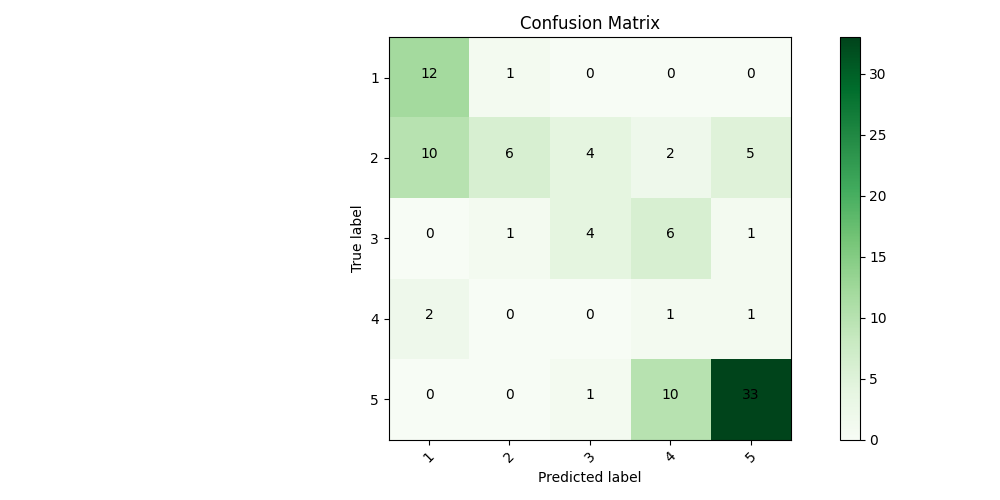

In [21]:
%matplotlib inline

from IPython.display import display
from PIL import Image
img_PIL = Image.open(r'confusion_matrix.png')
display(img_PIL)

In [22]:
from sagemaker.analytics import ExperimentAnalytics

import pandas as pd

pd.set_option("max_colwidth", 500)

experiment_analytics = ExperimentAnalytics(
    sagemaker_session=sess, experiment_name=experiment_name, sort_by="CreationTime", sort_order="Descending"
)

experiment_analytics_df = experiment_analytics.dataframe()
experiment_analytics_df
trial_component_name = experiment_analytics_df.TrialComponentName[0]
print(trial_component_name)

sagemaker-scikit-learn-2022-06-09-18-14-55-080-aws-processing-job


In [23]:
trial_component_description = sm.describe_trial_component(TrialComponentName=trial_component_name)
trial_component_description

{'CreatedBy': {},
 'CreationTime': datetime.datetime(2022, 6, 9, 18, 14, 56, 358000, tzinfo=tzlocal()),
 'DisplayName': 'evaluate',
 'EndTime': datetime.datetime(2022, 6, 9, 18, 22, 18, tzinfo=tzlocal()),
 'InputArtifacts': {'SageMaker.ImageUri': {'Value': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3'},
  'code': {'Value': 's3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-18-14-55-080/input/code/evaluate_model_metrics.py'},
  'evaluation-data-s3-uri': {'Value': 's3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv'},
  'model-tar-s3-uri': {'Value': 's3://sagemaker-us-east-1-390354360073/tensorflow-training-2022-06-09-14-48-54-028/output/'}},
 'LastModifiedBy': {},
 'LastModifiedTime': datetime.datetime(2022, 6, 9, 18, 22, 19, 466000, tzinfo=tzlocal()),
 'LineageGroupArn': 'arn:aws:sagemaker:us-east-1:390354360073:lineage-group/sagemaker-default-lineage-group',
 'Metrics': [],
 'OutputArtifacts': {'metrics': {'Value':

In [24]:
from sagemaker.lineage.visualizer import LineageTableVisualizer

lineage_table_viz = LineageTableVisualizer(sess)
lineage_table_viz_df = lineage_table_viz.show(processing_job_name=processing_evaluation_metrics_job_name)
lineage_table_viz_df

,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...080/input/code/evaluate_model_metrics.py,Input,DataSet,ContributedTo,artifact
1,s3://...st-1-390354360073/amazon-reviews-pds/tsv,Input,DataSet,ContributedTo,artifact
2,s3://...training-2022-06-09-14-48-54-028/output/,Input,DataSet,ContributedTo,artifact
3,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact
4,s3://...n-2022-06-09-18-14-55-080/output/metrics,Output,DataSet,Produced,artifact


![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec12.gif)

### Detect Model Bias using smclarify

- Bias: An imbalance in the training data or the prediction behavior of the model across different groups, such as age or income bracket. Biases can result from the data or algorithm used to train your model. For instance, if an ML model is trained primarily on data from middle-aged individuals, it may be less accurate when making predictions involving younger and older people.

- Bias metric: A function that returns numerical values indicating the level of a potential bias.

- Bias report: A collection of bias metrics for a given dataset, or a combination of a dataset and a model.

- Label: Feature that is the target for training a machine learning model. Referred to as the observed label or observed outcome.

- Positive label values: Label values that are favorable to a demographic group observed in a sample. In other words, designates a sample as having a positive result.

- Negative label values: Label values that are unfavorable to a demographic group observed in a sample. In other words, designates a sample as having a negative result.

- Facet: A column or feature that contains the attributes with respect to which bias is measured.

- Facet value: The feature values of attributes that bias might favor or disfavor.

**Post-training Bias Metrics**

- Difference in Positive Proportions in Predicted Labels (DPPL): Measures the difference in the proportion of positive predictions between the favored facet a and the disfavored facet d.

- Disparate Impact (DI): Measures the ratio of proportions of the predicted labels for the favored facet a and the disfavored facet d.

- Difference in Conditional Acceptance (DCAcc): Compares the observed labels to the labels predicted by a model and assesses whether this is the same across facets for predicted positive outcomes (acceptances).

- Difference in Conditional Rejection (DCR): Compares the observed labels to the labels predicted by a model and assesses whether this is the same across facets for negative outcomes (rejections).

- Recall Difference (RD): Compares the recall of the model for the favored and disfavored facets.

- Difference in Acceptance Rates (DAR): Measures the difference in the ratios of the observed positive outcomes (TP) to the predicted positives (TP + FP) between the favored and disfavored facets.

- Difference in Rejection Rates (DRR): Measures the difference in the ratios of the observed negative outcomes (TN) to the predicted negatives (TN + FN) between the disfavored and favored facets.

- Accuracy Difference (AD): Measures the difference between the prediction accuracy for the favored and disfavored facets.

- Treatment Equality (TE): Measures the difference in the ratio of false positives to false negatives between the favored and disfavored facets.

- Conditional Demographic Disparity in Predicted Labels (CDDPL): Measures the disparity of predicted labels between the facets as a whole, but also by subgroups.

- Counterfactual Fliptest (FT): Examines each member of facet d and assesses whether similar members of facet a have different model predictions.

In [26]:
from smclarify.bias.report import *
from smclarify.util.dataset import Datasets, german_lending_readable_values
from typing import Dict
from collections import defaultdict
import boto3
import sagemaker
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

We created test data in JSONLines format to match the model inputs.

In [27]:
data = {
    "star_rating": [1, 2, 3, 4, 5],
    "review_body": ["Worst ever", "Expected more", "Its ok", "I like it", "I love it"],
    "product_category": ["Gift Card", "Gift Card", "Gift Card", "Digital_Software", "Digital_Software"],
    "star_rating_predicted": [1, 2, 3, 4, 5],
}
df = pd.DataFrame(data, columns=["star_rating", "review_body", "product_category", "star_rating_predicted"])
df

,star_rating,review_body,product_category,star_rating_predicted
0,1,Worst ever,Gift Card,1
1,2,Expected more,Gift Card,2
2,3,Its ok,Gift Card,3
3,4,I like it,Digital_Software,4
4,5,I love it,Digital_Software,5


In [28]:
facet_column = FacetColumn(name="product_category", sensitive_values=["Gift Card"])
label_column = LabelColumn(name="star_rating", data=df["star_rating"], positive_label_values=[5, 4])
predicted_label_column = LabelColumn(
    name="star_rating_predicted", data=df["star_rating_predicted"], positive_label_values=[5, 4]
)

post_training_report = bias_report(
    df=df,
    facet_column=facet_column,
    label_column=label_column,
    stage_type=StageType.POST_TRAINING,
    predicted_label_column=predicted_label_column,
    metrics=["DPPL", "DI", "DCA", "DCR", "RD", "DAR", "DRR", "AD", "TE"],
)

from pprint import pprint
pprint(post_training_report)

[{'metrics': [{'description': 'Accuracy Difference (AD)',
               'name': 'AD',
               'value': 0.0},
              {'description': 'Difference in Acceptance Rates (DAR)',
               'name': 'DAR',
               'value': 1.0},
              {'description': 'Difference in Conditional Acceptance (DCA)',
               'name': 'DCA',
               'value': 1.0},
              {'description': 'Difference in Conditional Rejection (DCR)',
               'name': 'DCR',
               'value': 1.0},
              {'description': 'Disparate Impact (DI)',
               'name': 'DI',
               'value': 0.0},
              {'description': 'Difference in Positive Proportions in Predicted '
                              'Labels (DPPL)',
               'name': 'DPPL',
               'value': 1.0},
              {'description': 'Difference in Rejection Rates (DRR)',
               'name': 'DRR',
               'value': 1.0},
              {'description': 'Recall Difference (

/usr/local/lib/python3.7/dist-packages/smclarify/bias/report.py:378: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(facet_column.name, 1)
/usr/local/lib/python3.7/dist-packages/smclarify/bias/report.py:384: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(label_column.name, 1)
/usr/local/lib/python3.7/dist-packages/smclarify/bias/report.py:401: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(predicted_label_column.name, 1)


## Deployment

### Perform A/B Test using REST Endpoints

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/img8.png)

You can test and deploy new models behind a single SageMaker Endpoint with a concept called “production variants.” These variants can differ by hardware (CPU/GPU), by data (comedy/drama movies), or by region (US West or Germany North). You can shift traffic between the models in your endpoint for canary rollouts and blue/green deployments. You can split traffic for A/B tests. And you can configure your endpoint to automatically scale your endpoints out or in based on a given metric like requests per second. As more requests come in, SageMaker will automatically scale the model prediction API to meet the demand.



In [30]:
!aws s3 cp s3://$bucket/$training_job_name/output/model.tar.gz ./model.tar.gz

download: s3://sagemaker-us-east-1-390354360073/tensorflow-training-2022-06-09-14-48-54-028/output/model.tar.gz to ./model.tar.gz


In [31]:
!mkdir -p ./model/
!tar -xvzf ./model.tar.gz -C ./model/

code/
tensorboard/
tensorboard/validation/
tensorboard/validation/events.out.tfevents.1654786893.ip-10-0-101-8.ec2.internal.90.25864.v2
tensorboard/validation/events.out.tfevents.1654788259.ip-10-0-101-8.ec2.internal.90.29704.v2
tensorboard/train/
tensorboard/train/events.out.tfevents.1654786420.ip-10-0-101-8.ec2.internal.profile-empty
tensorboard/train/events.out.tfevents.1654786382.ip-10-0-101-8.ec2.internal.90.5924.v2
tensorboard/train/plugins/
tensorboard/train/plugins/profile/
tensorboard/train/plugins/profile/2022_06_09_14_53_40/
tensorboard/train/plugins/profile/2022_06_09_14_53_40/ip-10-0-101-8.ec2.internal.tensorflow_stats.pb
tensorboard/train/plugins/profile/2022_06_09_14_53_40/ip-10-0-101-8.ec2.internal.overview_page.pb
tensorboard/train/plugins/profile/2022_06_09_14_53_40/ip-10-0-101-8.ec2.internal.memory_profile.json.gz
tensorboard/train/plugins/profile/2022_06_09_14_53_40/ip-10-0-101-8.ec2.internal.xplane.pb
tensorboard/train/plugins/profile/2022_06_09_14_53_40/ip-10-0-10

In [32]:
!saved_model_cli show --all --dir ./model/tensorflow/saved_model/0/


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_ids'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 64)
        name: serving_default_input_ids:0
    inputs['input_mask'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 64)
        name: serving_default_input_mask:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concr

In [33]:
%%writefile model/code/inference.py
import json
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow==2.3.1"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers==3.5.1"])
# Workaround for https://github.com/huggingface/tokenizers/issues/120 and
#                https://github.com/kaushaltrivedi/fast-bert/issues/174
# subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', 'tokenizers'])

import tensorflow as tf
from transformers import DistilBertTokenizer

classes = [1, 2, 3, 4, 5]

max_seq_length = 64

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


def input_handler(data, context):
    data_str = data.read().decode("utf-8")
    print("data_str: {}".format(data_str))
    print("type data_str: {}".format(type(data_str)))

    jsonlines = data_str.split("\n")
    print("jsonlines: {}".format(jsonlines))
    print("type jsonlines: {}".format(type(jsonlines)))

    transformed_instances = []

    for jsonline in jsonlines:
        print("jsonline: {}".format(jsonline))
        print("type jsonline: {}".format(type(jsonline)))

        # features[0] is review_body
        # features[1..n] are others (ie. 1: product_category, etc)
        review_body = json.loads(jsonline)["features"][0]
        print("""review_body: {}""".format(review_body))

        encode_plus_tokens = tokenizer.encode_plus(
            review_body, 
            padding='max_length', 
            max_length=max_seq_length, 
            truncation=True
        )

        # Convert the text-based tokens to ids from the pre-trained BERT vocabulary
        input_ids = encode_plus_tokens["input_ids"]

        # Specifies which tokens BERT should pay attention to (0 or 1)
        input_mask = encode_plus_tokens["attention_mask"]

        transformed_instance = {"input_ids": input_ids, "input_mask": input_mask}

        transformed_instances.append(transformed_instance)

    transformed_data = {"signature_name": "serving_default", "instances": transformed_instances}

    transformed_data_json = json.dumps(transformed_data)
    print("transformed_data_json: {}".format(transformed_data_json))

    return transformed_data_json


def output_handler(response, context):
    print("response: {}".format(response))
    response_json = response.json()
    print("response_json: {}".format(response_json))

    outputs_list = response_json["predictions"]
    print("outputs_list: {}".format(outputs_list))

    predicted_classes = []

    for outputs in outputs_list:
        print("outputs in loop: {}".format(outputs))
        print("type(outputs) in loop: {}".format(type(outputs)))

        predicted_class_idx = tf.argmax(outputs, axis=-1, output_type=tf.int32)
        predicted_class = classes[predicted_class_idx]
        print("predicted_class: {}".format(predicted_class))

        prediction_dict = {}
        prediction_dict["predicted_label"] = predicted_class

        jsonline = json.dumps(prediction_dict)
        print("jsonline: {}".format(jsonline))

        predicted_classes.append(jsonline)
        print("predicted_classes in the loop: {}".format(predicted_classes))

    predicted_classes_jsonlines = "\n".join(predicted_classes)
    print("predicted_classes_jsonlines: {}".format(predicted_classes_jsonlines))

    response_content_type = context.accept_header

    return predicted_classes_jsonlines, response_content_type

Writing model/code/inference.py


#### Create Variant A Model From the Training Job in a Previous Section

In [34]:
inference_image_uri = sagemaker.image_uris.retrieve(
    framework="tensorflow",
    region=region,
    version="2.3.1",
    py_version="py37",
    instance_type="ml.m5.4xlarge",
    image_scope="inference",
)
print(inference_image_uri)

import time

timestamp = "{}".format(int(time.time()))

model_a_name = "{}-{}-{}".format(training_job_name, "varianta", timestamp)

sess.create_model_from_job(
    name=model_a_name, training_job_name=training_job_name, role=role, image_uri=inference_image_uri
)

763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu


'tensorflow-training-2022-06-09-14-48-54-028-varianta-1654802402'

#### Create Variant B Model From the Training Job in a Previous Section

In [35]:
model_b_name = "{}-{}-{}".format(training_job_name, "variantb", timestamp)

sess.create_model_from_job(
    name=model_b_name, training_job_name=training_job_name, role=role, image_uri=inference_image_uri
)

'tensorflow-training-2022-06-09-14-48-54-028-variantb-1654802402'

#### Canary Rollouts and A/B Testing

Canary rollouts are used to release new models safely to only a small subset of users such as 5%. They are useful if you want to test in live production without affecting the entire user base. Since the majority of traffic goes to the existing model, the cluster size of the canary model can be relatively small since it’s only receiving 5% traffic.

Instead of deploy(), we can create an Endpoint Configuration with multiple variants for canary rollouts and A/B testing.

In [36]:
from sagemaker.session import production_variant

timestamp = "{}".format(int(time.time()))

endpoint_config_name = "{}-{}-{}".format(training_job_name, "abtest", timestamp)

variantA = production_variant(
    model_name=model_a_name,
    instance_type="ml.m5.4xlarge",
    initial_instance_count=1,
    variant_name="VariantA",
    initial_weight=50,
)

variantB = production_variant(
    model_name=model_b_name,
    instance_type="ml.m5.4xlarge",
    initial_instance_count=1,
    variant_name="VariantB",
    initial_weight=50,
)

endpoint_config = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name, ProductionVariants=[variantA, variantB]
)

model_ab_endpoint_name = "{}-{}-{}".format(training_job_name, "abtest", timestamp)

endpoint_response = sm.create_endpoint(EndpointName=model_ab_endpoint_name, EndpointConfigName=endpoint_config_name)

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec13.gif)

#### Track the Deployment Within our Experiment

In [37]:
from smexperiments.trial import Trial

timestamp = "{}".format(int(time.time()))

trial = Trial.load(trial_name=trial_name)
print(trial)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Trial(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f3abd18b410>,trial_name='trial-1654775455',trial_arn='arn:aws:sagemaker:us-east-1:390354360073:experiment-trial/trial-1654775455',display_name='trial-1654775455',experiment_name='Amazon-Customer-Reviews-BERT-Experiment-1654775428',creation_time=datetime.datetime(2022, 6, 9, 11, 50, 55, 679000, tzinfo=tzlocal()),created_by={},last_modified_time=datetime.datetime(2022, 6, 9, 18, 22, 19, 466000, tzinfo=tzlocal()),last_modified_by={},response_metadata={'RequestId': 'bc8f9638-5e35-4d18-b058-dbbefa6f68f5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'bc8f9638-5e35-4d18-b058-dbbefa6f68f5', 'content-type': 'application/x-amz-json-1.1', 'content-length': '326', 'date': 'Thu, 09 Jun 2022 19:24:08 GMT'}, 'RetryAttempts': 0})


In [38]:
from smexperiments.tracker import Tracker

tracker_deploy = Tracker.create(display_name="deploy", sagemaker_boto_client=sm)

deploy_trial_component_name = tracker_deploy.trial_component.trial_component_name
print("Deploy trial component name {}".format(deploy_trial_component_name))

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Deploy trial component name TrialComponent-2022-06-09-192501-vlgb


In [39]:
# Attach the deploy Trial Component and Tracker as a Component to the Trial
trial.add_trial_component(tracker_deploy.trial_component)

# Track the Endpoint Name
tracker_deploy.log_parameters(
    {
        "endpoint_name": model_ab_endpoint_name,
    }
)

# must save after logging
tracker_deploy.trial_component.save()

from sagemaker.analytics import ExperimentAnalytics

lineage_table = ExperimentAnalytics(
    sagemaker_session=sess,
    experiment_name=experiment_name,
    metric_names=["validation:accuracy"],
    sort_by="CreationTime",
    sort_order="Ascending",
)

lineage_df = lineage_table.dataframe()
lineage_df.shape

(3, 71)

In [40]:
lineage_df

,TrialComponentName,DisplayName,SourceArn,AWS_DEFAULT_REGION,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,SageMaker.ImageUri - MediaType,SageMaker.ImageUri - Value,code - MediaType,...,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,evaluation-data-s3-uri - MediaType,evaluation-data-s3-uri - Value,model-tar-s3-uri - MediaType,model-tar-s3-uri - Value,metrics - MediaType,metrics - Value
0,sagemaker-scikit-learn-2022-06-09-11-58-05-034-aws-processing-job,prepare,arn:aws:sagemaker:us-east-1:390354360073:processing-job/sagemaker-scikit-learn-2022-06-09-11-58-05-034,us-east-1,2.0,ml.c5.2xlarge,30.0,NaN,683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tensorflow-training-2022-06-09-14-48-54-028-aws-training-job,train,arn:aws:sagemaker:us-east-1:390354360073:training-job/tensorflow-training-2022-06-09-14-48-54-028,NaN,1.0,ml.c5.9xlarge,1024.0,NaN,NaN,NaN,...,NaN,s3://sagemaker-us-east-1-390354360073/,NaN,s3://sagemaker-us-east-1-390354360073/tensorflow-training-2022-06-09-14-48-54-028/output/model.tar.gz,NaN,NaN,NaN,NaN,NaN,NaN
2,sagemaker-scikit-learn-2022-06-09-18-14-55-080-aws-processing-job,evaluate,arn:aws:sagemaker:us-east-1:390354360073:processing-job/sagemaker-scikit-learn-2022-06-09-18-14-55-080,NaN,1.0,ml.m5.xlarge,30.0,NaN,683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3,NaN,...,NaN,NaN,NaN,NaN,NaN,s3://sagemaker-us-east-1-390354360073/amazon-reviews-pds/tsv,NaN,s3://sagemaker-us-east-1-390354360073/tensorflow-training-2022-06-09-14-48-54-028/output/,NaN,s3://sagemaker-us-east-1-390354360073/sagemaker-scikit-learn-2022-06-09-18-14-55-080/output/metrics


In [41]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

![](https://github.com/sparsh-ai/book-data-science-on-aws/raw/main/img/rec14.gif)

In [ ]:
# Simulate a Prediction from an Application
from sagemaker.tensorflow.model import TensorFlowPredictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

predictor = TensorFlowPredictor(
    endpoint_name=model_ab_endpoint_name,
    sagemaker_session=sess,
    model_name="saved_model",
    model_version=0,
    content_type="application/jsonlines",
    accept_type="application/jsonlines",
    serializer=JSONLinesSerializer(),
    deserializer=JSONLinesDeserializer(),
)

# Waiting for the Endpoint to be ready to Serve Predictions
import time

time.sleep(30)

In [ ]:
# Predict the star_rating with Ad Hoc review_body Samples
inputs = [{"features": ["This is great!"]}, {"features": ["This is bad."]}]

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted star_rating: {}".format(predicted_class))

#### Shift All Traffic to Variant B

In [ ]:
updated_endpoint_config = [
    {
        "VariantName": variantA["VariantName"],
        "DesiredWeight": 0,
    },
    {
        "VariantName": variantB["VariantName"],
        "DesiredWeight": 100,
    },
]

sm.update_endpoint_weights_and_capacities(
    EndpointName=model_ab_endpoint_name, DesiredWeightsAndCapacities=updated_endpoint_config
)

waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

#### Remove Variant A to Reduce Cost

In [ ]:
import time

timestamp = "{}".format(int(time.time()))

updated_endpoint_config_name = "{}-{}".format(training_job_name, timestamp)

updated_endpoint_config = sm.create_endpoint_config(
    EndpointConfigName=updated_endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": variantB["VariantName"],
            "ModelName": model_b_name,  # Only specify variant B to remove variant A
            "InstanceType": "ml.m5.4xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 100,
        }
    ],
)

sm.update_endpoint(EndpointName=model_ab_endpoint_name, EndpointConfigName=updated_endpoint_config_name)

waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

The End.

Thank You for your patience.